# **Background Fit Demo**
---

This script runs through the main() function from do_bkg_estimation_wPSs_mp2.py using event data from the Example_LLH_setup_fixed_dirs.ipynb notebook. In the aforementioned notebook, the completed background fit is read in from a .csv file, bypassing the need to run the background estimation process. Here, we go through the background fitting process and show step-by-step how the background fitting process functions.

Starting first with the necessary imports copied from the notebook.

In [31]:
import numpy as np
from astropy.io import fits # FITS -> Flexible Image Transport System.
from astropy.table import Table, vstack # astropy.table provides functionality
                                        # for storing and manipulating 
                                        # tables of data familiar to numpy users.
                                        # Table is the generic object for 
                                        # creating tables and vstack is a function
                                        # for stacking multiple tables vertically 
                                        # along rows.
from astropy.wcs import WCS # WCS -> World Coordinate System. The library 
                            # contains utilities for managing WCS 
                            # transformations defined in FITS WCS standard 
                            # conventions.
import os
import argparse
import logging, traceback   # logging odule defines functions and classes which
                            # implement a flexible even logging system for 
                            # applications and libraries. traceback provides 
                            # inverface to extract, format and print stack
                            # traces of python programs.
import pandas as pd
from copy import copy, deepcopy # for compound objects (objects that contain 
                            # other objects) a shallow copy constructs a new 
                            # compound object and then inserts references into
                            # it to the objects found in the original. The 
                            # function copy performs a shallow copy. deepcopy
                            # performs a deep copy which constructs a new 
                            # compound object and then, recursively, inserts 
                            # copies into it of the objects found in the original.
import multiprocessing as mp # This library allows the programmer to fully
                             # leverage multiple processors on a given machine.
import matplotlib.pyplot as plt


In [32]:
# Change directory to the same directory as do_bkg_estimation_wPSs_mp2.py
os.getcwd()
os.chdir('/Volumes/WD/Development/Programming/NITRATES_RESP_DIR_PIP/NITRATES/nitrates/llh_analysis/')
print(os.getcwd())

/Volumes/WD/Development/Programming/NITRATES_RESP_DIR_PIP/NITRATES/nitrates/llh_analysis


In [33]:
from nitrates.analysis_seeds.bkg_rate_estimation import get_avg_lin_cub_rate_quad_obs
from nitrates.config import quad_dicts, EBINS0, EBINS1,\
                solid_angle_dpi_fname, bright_source_table_fname
from nitrates.lib.sqlite_funcs import write_rate_fits_from_obj, get_conn
from nitrates.lib.dbread_funcs import get_info_tab, guess_dbfname, get_files_tab
from nitrates.lib.event2dpi_funcs import filter_evdata
from nitrates.models.models import Bkg_Model_wFlatA, CompoundModel, Point_Source_Model_Binned_Rates
from nitrates.llh_analysis.LLH import LLH_webins
from nitrates.llh_analysis.minimizers import NLLH_ScipyMinimize, NLLH_ScipyMinimize_Wjacob
from nitrates.response.ray_trace_funcs import RayTraces
from nitrates.lib.coord_conv_funcs import convert_radec2imxy
from nitrates.lib.gti_funcs import add_bti2gti, bti2gti, gti2bti, union_gtis
from nitrates.lib.wcs_funcs import world2val
import nitrates

Here, we are copying the functions that are defined within do_bkg_estimation_wPSs_mp2.py and utilized within its main() function.

In [34]:

def ang_sep(ra0, dec0, ra1, dec1):

    dcos = np.cos(np.radians(np.abs(ra0 - ra1)))
    angsep = np.arccos(np.cos(np.radians(90-dec0))*np.cos(np.radians(90-dec1)) +\
                        np.sin(np.radians(90-dec0))*np.sin(np.radians(90-dec1))*dcos)
    return np.rad2deg(angsep)

def im_dist(imx0, imy0, imx1, imy1):
    return np.hypot((imx1 - imx0), (imy1 - imy0))

def add_imxy2src_tab(src_tab, attfile, t0):

    att_ind = np.argmin(np.abs(attfile['TIME'] - t0))
    att_quat = attfile['QPARAM'][att_ind]
    pnt_ra, pnt_dec = attfile['POINTING'][att_ind,:2]
    imxs = np.zeros(len(src_tab))
    imys = np.zeros(len(src_tab))
    src_tab['PntSep'] = ang_sep(pnt_ra, pnt_dec, src_tab['RAJ2000'], src_tab['DEJ2000'])
    for i in range(len(imxs)):
        if src_tab['PntSep'][i] > 80.0:
            imxs[i], imys[i] = np.nan, np.nan
            continue
        imxs[i], imys[i] = convert_radec2imxy(src_tab['RAJ2000'][i],\
                                              src_tab['DEJ2000'][i],\
                                              att_quat)
    src_tab['imx'] = imxs
    src_tab['imy'] = imys
    return src_tab

def get_srcs_infov(attfile, t0, pcfname=None, pcmin=5e-2):

    brt_src_tab = Table.read(bright_source_table_fname)
    add_imxy2src_tab(brt_src_tab, attfile, t0)
    bl_infov = (np.abs(brt_src_tab['imy'])<.95)&(np.abs(brt_src_tab['imx'])<1.75)
    if pcfname is not None:
        try:
            PC = fits.open(pcfname)[0]
            pc = PC.data
            w_t = WCS(PC.header, key='T')
            pcvals = world2val(w_t, pc, brt_src_tab['imx'],\
                                brt_src_tab['imy'])
            bl_infov = bl_infov&(pcvals>=pcmin)
        except Exception as E:
            logging.warn("Trouble Using PC file")
            logging.error(E)
    N_infov = np.sum(bl_infov)
    return brt_src_tab[bl_infov]


def min_by_ebin(miner, params_):

    nebins = miner.llh_obj.nebins
    params = copy(params_)
    bf_params = copy(params_)
    NLLH = 0.0

    for e0 in range(nebins):
        miner.set_fixed_params(list(params.keys()), values=list(params.values()))
        e0_pnames = []
        for pname in miner.param_names:
            try:
                if int(pname[-1])==e0:
                    e0_pnames.append(pname)
            except:
                pass
        miner.set_fixed_params(e0_pnames, fixed=False)
        miner.llh_obj.set_ebin(e0)

        bf_vals, nllh, res = miner.minimize()
        NLLH += nllh[0]
        for ii, pname in enumerate(e0_pnames):
            bf_params[pname] = bf_vals[0][ii]

    return NLLH, bf_params

class Worker(mp.Process):

    def __init__(self, result_queue, miner, param_list):

        mp.Process.__init__(self)
        self.miner = miner
        self.param_list = param_list
        self.result_queue = result_queue

    def run(self):
        proc_name = self.name

        for params in self.param_list:

            nllh, bf_params = min_by_ebin(self.miner, params)
            res_dict = bf_params
            res_dict['nllh'] = nllh
            self.result_queue.put(res_dict)


        self.result_queue.put(None)
        return


def bkg_withPS_fit(PS_tab, model, llh_obj, t0s, t1s,\
                   dimxy=2e-3, im_steps=5, test_null=False,\
                   Nprocs=1):

    Nps = len(PS_tab)
    imax = np.linspace(-dimxy, dimxy, im_steps)
    if im_steps == 3:
        imax = np.linspace(-dimxy/2., dimxy/2., im_steps)
    elif im_steps == 2:
        imax = np.linspace(-dimxy/2., dimxy/2., im_steps)
        imax0 = [-dimxy, 0.0, dimxy]
        imax1 = [dimxy, 0.0, -dimxy]
    elif im_steps == 1:
        imax = np.array([0.0])


    imlist = []
    for i in range(Nps):
        if im_steps == 2:
            imlist += [imax0,imax1]
        else:
            imlist += [imax,imax]
    imgs = np.meshgrid(*imlist)
    Npnts = imgs[0].size
    if im_steps == 2:
        ind_grids = np.meshgrid(*(np.arange(3, dtype=np.int) for i in range(Nps)))
        Npnts = ind_grids[0].size
    logging.info("Npnts: %d"%(Npnts))

    bkg_miner = NLLH_ScipyMinimize_Wjacob('')
    bkg_miner.set_llh(llh_obj)
    llh_obj.set_time(t0s,t1s)

    bf_params_list = []
    bkg_nllhs = np.zeros(Npnts)

    for i in range(Npnts):
        bf_params = {}
        im_names = []
        params_ = {pname:val['val'] for pname, val in bkg_miner.param_info_dict.items()}


        for j in range(Nps):
            row = PS_tab[j]
            psname = row['Name']
            if im_steps == 2:
                params_[psname+'_imx'] = imlist[2*j][ind_grids[j].ravel()[i]] + row['imx']
                params_[psname+'_imy'] = imlist[2*j+1][ind_grids[j].ravel()[i]] + row['imy']
            else:
                params_[psname+'_imx'] = imgs[2*j].ravel()[i] + row['imx']
                params_[psname+'_imy'] = imgs[2*j+1].ravel()[i] + row['imy']
            im_names = [psname+'_imx', psname+'_imy']
#         im_vals = [bf_params[nm] for nm in im_names]
        if Nprocs > 1:
            param_list.append(params_)
            continue
        im_vals = [params_[nm] for nm in im_names]

        bkg_nllhs[i], bf_params = min_by_ebin(bkg_miner, params_)

        bf_params_list.append(bf_params)

    if Nprocs > 1:

        res_q = mp.Queue()
        workers = []
        Nper_worker = 1 + int(len(param_list)/(1.*Nprocs))
        logging.info("Nper_worker: %d"%(Nper_worker))
        for i in range(Nprocs):
            i0 = i*Nper_worker
            i1 = i0 + Nper_worker
            w = Worker(res_q, deepcopy(bkg_miner), param_list[i0:i1])
            workers.append(w)

        for w in workers:
            w.start()
        res_dicts = []
        Ndone = 0
        while True:
            res = res_q.get()
            if res is None:
                Ndone += 1
                logging.info("%d of %d done"%(Ndone, Nprocs))
                if Ndone >= Nprocs:
                    break
            else:
                res_dicts.append(res)
        for w in workers:
            w.join()

        df = pd.DataFrame(res_dicts)
        min_ind = np.argmin(df['nllh'])
        bf_df_row = df.iloc[min_ind]
        bf_nllh = bf_df_row['nllh']
        bf_params = {name:bf_df_row[name] for name in bf_df_row.index if\
                         not 'nllh' in name}


    else:
        bf_ind = np.argmin(bkg_nllhs)
        bf_params = bf_params_list[bf_ind]
        bf_nllh = bkg_nllhs[bf_ind]

    if test_null:
        TS_nulls = {}
        for i in range(Nps):
            params_ = copy(bf_params)
            row = PS_tab[i]
            psname = row['Name']
            for j in range(nebins):
                params_[psname+'_rate_'+str(j)] = 0.0
            llh_obj.set_ebin(-1)
            nllh_null = -llh_obj.get_logprob(params_)
            TS_nulls[psname] = np.sqrt(2.*(nllh_null - bf_nllh))
            if np.isnan(TS_nulls[psname]):
                TS_nulls[psname] = 0.0
        return bf_nllh, bf_params, TS_nulls


    return bf_nllh, bf_params



def do_init_bkg_wPSs(bkg_mod, llh_obj, src_tab, rt_obj, GTI, sig_twind,\
                    TSmin=7.0, Nprocs=1, tmin=None, tmax=None):

    if not tmin is None:
        bti = (-np.inf, tmin)
        GTI = add_bti2gti(bti, GTI)
    if not tmax is None:
        bti = (tmax, np.inf)
        GTI = add_bti2gti(bti, GTI)
    gti_bkg = add_bti2gti(sig_twind, GTI)
    bkg_t0s = gti_bkg['START']
    bkg_t1s = gti_bkg['STOP']
    exp = 0.0
    for i in range(len(bkg_t0s)):
        exp += (bkg_t1s[i] - bkg_t0s[i])
    logging.info("exp: %.3f"%(exp))
    # if exp < 30.0:
    #     logging.info("Trying to expand sig_twind")
    #     sig_twind = (sig_twind[0] + 20.0, sig_twind[1] - 20.0)
    #     gti_bkg = add_bti2gti(sig_twind, GTI_)
    #     bkg_t0s = gti_bkg['START']
    #     bkg_t1s = gti_bkg['STOP']
    #     exp = 0.0
    #     for i in range(len(bkg_t0s)):
    #         exp += (bkg_t1s[i] - bkg_t0s[i])
    #     logging.info("exp: %.3f"%(exp))

    logging.info("bkg_t0s: ")
    logging.info(bkg_t0s)
    logging.info("bkg_t1s: ")
    logging.info(bkg_t1s)


    Nsrcs = len(src_tab)
    nebins = bkg_mod.nebins

    for ii in range(Nsrcs):
        mod_list = [bkg_mod]
        im_steps = 5
        TSmin_ = TSmin
        if Nsrcs >= 3:
            im_steps = 3
            TSmin_ = TSmin - 1.0
        if Nsrcs >= 5:
            im_steps = 2
            TSmin_ = TSmin - 1.5
        if Nsrcs >= 9:
            im_steps = 1
            TSmin_ = TSmin - 2.5

        ps_mods = []
        for i in range(Nsrcs):
            row = src_tab[i]
            mod = Point_Source_Model_Binned_Rates(row['imx'], row['imy'], 0.1,\
                                                  [llh_obj.ebins0,llh_obj.ebins1],\
                                                  rt_obj, llh_obj.bl_dmask,\
                                                  use_deriv=True, name=row['Name'])
            ps_mods.append(mod)

        mod_list += ps_mods
        comp_mod = CompoundModel(mod_list)

        llh_obj.set_model(comp_mod)

        bf_nllh, bf_params, TS_nulls = bkg_withPS_fit(src_tab, comp_mod,\
                                      llh_obj, bkg_t0s, bkg_t1s,\
                                      test_null=True, im_steps=im_steps,\
                                        Nprocs=Nprocs)

        logging.debug("TS_nulls: ")
        logging.debug(TS_nulls)

        bkg_rates = np.array([bf_params['Background'+'_bkg_rate_'+str(j)]\
                            for j in range(nebins)])
        min_rate = 1e-1*bkg_rates
        logging.debug("min_rate: ")
        logging.debug(min_rate)
        PSs2keep = []

        # Going through all of the point sources and checking that the if the 
        # test statistic is below our minimum rate, we exclude the point source 
        # from the background
        for name, TS in TS_nulls.items():
            ps_rates = np.array([bf_params[name+'_rate_'+str(j)] for j in range(nebins)])
            logging.debug(name + " rates: ")
            logging.debug(ps_rates)
            if TS < TSmin_:
                # ps_rates = np.array([bf_params[name+'_rate_'+str(j)] for j in range(nebins)])
                # print ps_rates
                if np.all(ps_rates<min_rate):
                    continue
            if np.all(ps_rates<(min_rate/20.)):
                continue
            PSs2keep.append(name)

        # errs_dict = {}
        # corrs_dict = {}
        # for e0 in range(nebins):
        #     flat_pname = 'Background_flat_'+str(e0)
        #     comp_mod.param_dict[flat_pname]['fixed'] = True
        #     comp_mod.param_dict[flat_pname]['val'] = bf_params[flat_pname]
        #     err_dict, corr_dict = get_errs_corrs(llh_obj, comp_mod, copy(bf_params),\
        #                                          e0, pnames2skip=[flat_pname])
        #     for k, val in err_dict.iteritems():
        #         errs_dict[k] = val
        #     for k, val in corr_dict.iteritems():
        #         corrs_dict[k] = val


        if len(PSs2keep) == len(src_tab):
            break
        if len(PSs2keep) == 0:
            Nsrcs = 0
            src_tab = src_tab[np.zeros(len(src_tab), dtype=np.bool)]
            break
        bl = np.array([src_tab['Name'][i] in PSs2keep for i in range(Nsrcs)])
        src_tab = src_tab[bl]
        Nsrcs = len(src_tab)
        logging.debug("src_tab: ")
        logging.debug(src_tab)

    return bf_params, src_tab#, errs_dict, corrs_dict



def get_info_mat_around_min(llh_obj, mod, params_, ebin):

    params = copy(params_)
    dt = llh_obj.dt
    mod_cnts = llh_obj.model.get_rate_dpi(params, ebin)*dt
    data_cnts = llh_obj.data_dpis[ebin]

    dR_dparams = mod.get_dr_dp(params, ebin)

    cov_ndim = len(dR_dparams)

    info_mat = np.zeros((cov_ndim,cov_ndim))

    for i in range(cov_ndim):
        for j in range(cov_ndim):
            info_mat[i,j] = np.sum(((dR_dparams[j]*dt)*(dR_dparams[i]*dt)*\
                                    data_cnts)/np.square(mod_cnts))
#             cov_mat[i,j] = np.sum(np.square(mod_cnts)/\
#                         ((dR_dparams[j]*dt)*(dR_dparams[i]*dt)*data_cnts))

    return info_mat


def get_errs_corrs(llh_obj, model, params, e0, pnames2skip=[]):

    imat = get_info_mat_around_min(llh_obj, model, copy(params), e0)
    cov_mat = np.linalg.inv(imat)
    e0_pnames = []
    for pname in model.param_names:
        try:
            if int(pname[-1])==e0 and not (pname in pnames2skip):
                e0_pnames.append(pname)
        except:
            pass

    err_dict = {}
    corr_dict = {}
    errs = np.sqrt(np.diag(cov_mat))
    for i, pname in enumerate(e0_pnames):
        k = 'err_' + pname
        err_dict[k] = errs[i]
    Npars = len(e0_pnames)
    for i in range(Npars-1):
        pname0 = e0_pnames[i]
        for j in range(i+1,Npars):
            pname1 = e0_pnames[j]
            k = 'corr_' + pname0 + '_' + pname1
            corr_dict[k] = cov_mat[i,j]/(errs[i]*errs[j])

    return err_dict, corr_dict


def bkg_withPS_fit_fiximxy(PS_tab, model, llh_obj, t0s, t1s, params_,\
                           fixed_pnames=None):

    Nps = len(PS_tab)
    params = copy(params_)

    llh_obj.set_model(model)
    bkg_miner = NLLH_ScipyMinimize_Wjacob('')
    bkg_miner.set_llh(llh_obj)
    llh_obj.set_time(t0s,t1s)

    nllh = 0.0
#     bf_params = {fixed_pars[i]:fixed_vals[i] for i in range(len(fixed_pars))}
    bf_params = copy(params)
    fixed_vals = [bf_params[pname] for pname in fixed_pnames]
    errs_dict = {}
    corrs_dict = {}

    # For each energy bin 
    for e0 in range(llh_obj.nebins):
        bkg_miner.set_fixed_params(bkg_miner.param_names)
        if fixed_pnames is not None:
            bkg_miner.set_fixed_params(fixed_pnames, values=fixed_vals)
        e0_pnames = []
        for pname in bkg_miner.param_names:
            try:
                if int(pname[-1])==e0 and not (pname in fixed_pnames):
                    e0_pnames.append(pname)
            except:
                pass
        bkg_miner.set_fixed_params(e0_pnames, fixed=False)
        llh_obj.set_ebin(e0)

        bf_vals, bkg_nllh, res = bkg_miner.minimize()
        nllh += bkg_nllh[0]
        for ii, pname in enumerate(e0_pnames):
            bf_params[pname] = bf_vals[0][ii]

        print(bf_params)

        err_dict, corr_dict = get_errs_corrs(llh_obj, model, copy(bf_params), e0, pnames2skip=fixed_pnames)
        for k, val in err_dict.items():
            errs_dict[k] = val
        for k, val in corr_dict.items():
            corrs_dict[k] = val

    return nllh, bf_params, errs_dict, corrs_dict



In [35]:
NITRATES_path=nitrates.config.NITRATES_RESP_DIR
work_dir = os.path.join(NITRATES_path, 'F646018360')
conn = get_conn(os.path.join(work_dir,'results.db'))
info_tab = get_info_tab(conn)
files_tab = get_files_tab(conn)

trigtime = info_tab['trigtimeMET'][0]

In [36]:
files_tab
# Here we have a table with evfname, detmask, attfname, drmDir, rtDir, 
# workDir batmlDir, and SkymapFname 


evfname  \
0  /storage/work/jjd330/local/bat_data/realtime_w...   
1  /storage/home/j/jjd330/work/local/bat_data/rea...   

                                             detmask  \
0  /storage/work/jjd330/local/bat_data/realtime_w...   
1  /storage/home/j/jjd330/work/local/bat_data/rea...   

                                            attfname  \
0  /storage/work/jjd330/local/bat_data/realtime_w...   
1  /storage/home/j/jjd330/work/local/bat_data/rea...   

                                      drmDir  \
0  /storage/work/jjd330/local/bat_data/drms/   
1  /storage/work/jjd330/local/bat_data/drms/   

                                               rtDir  \
0  /gpfs/scratch/jjd330/bat_data/ray_traces_detap...   
1  /gpfs/scratch/jjd330/bat_data/ray_traces_detap...   

                                             workDir  \
0  /storage/work/jjd330/local/bat_data/realtime_w...   
1  /storage/home/j/jjd330/work/local/bat_data/rea...   

                                     batmlDir SkymapFname pcodeFname  
0  /storage/work/jjd330/local/bat_data/BatML/        None       None  
1  /storage/work/jjd330/local/bat_data/BatML/        None       None

It is a good idea to be familiarized (if not already familiar) with the format of the fits data. The fits data is represented as a table of values with corresponding value types indicated in dtype.

In [37]:
evfname = os.path.join(work_dir,'filter_evdata.fits')
ev_data = fits.open(evfname)[1].data
ev_data

FITS_rec([(6.46018333e+08,  1346, 0, 2685, 0.0000000e+00,  25, 134,  252,  25.2, 0),
          (6.46018333e+08, 14333, 0, 2699, 5.1307690e-04, 234, 104,  229,  22.9, 0),
          (6.46018333e+08, 18679, 0, 2420, 0.0000000e+00,  68,   0,  562,  56.2, 0),
          ...,
          (6.46018533e+08, 14227, 0, 1744, 5.9490534e-04, 247, 103, 2004, 200.4, 0),
          (6.46018533e+08, 12353, 0, 2462, 8.8046494e-05, 223, 155,  621,  62.1, 0),
          (6.46018533e+08, 23871, 0, 2287, 0.0000000e+00, 115,  40,  923,  92.3, 0)],
         dtype=(numpy.record, [('TIME', '>f8'), ('DET_ID', '>i2'), ('EVENT_FLAGS', 'u1'), ('PHA', '>i2'), ('MASK_WEIGHT', '>f4'), ('DETX', '>i2'), ('DETY', '>i2'), ('PI', '>i2'), ('ENERGY', '>f8'), ('SLEW', '>i8')]))

Calling upon the column name of a fits table displays all values underneath that particular column. Here we print all DETX and DETY values for all the event data.

In [38]:
print(ev_data['DETX'])
print(ev_data['DETY'])

[ 25 234  68 ... 247 223 115]
[134 104   0 ... 103 155  40]


 Plotting all event data across the detector plane for all times. Essentially, this view of the data shows every detector that registered a count during the ellapsed time. Note that the detector array is indeed a rectangular array of detector grids. The empty areas of the dpi indicate detectors that were not functional during the timeframe of the data.

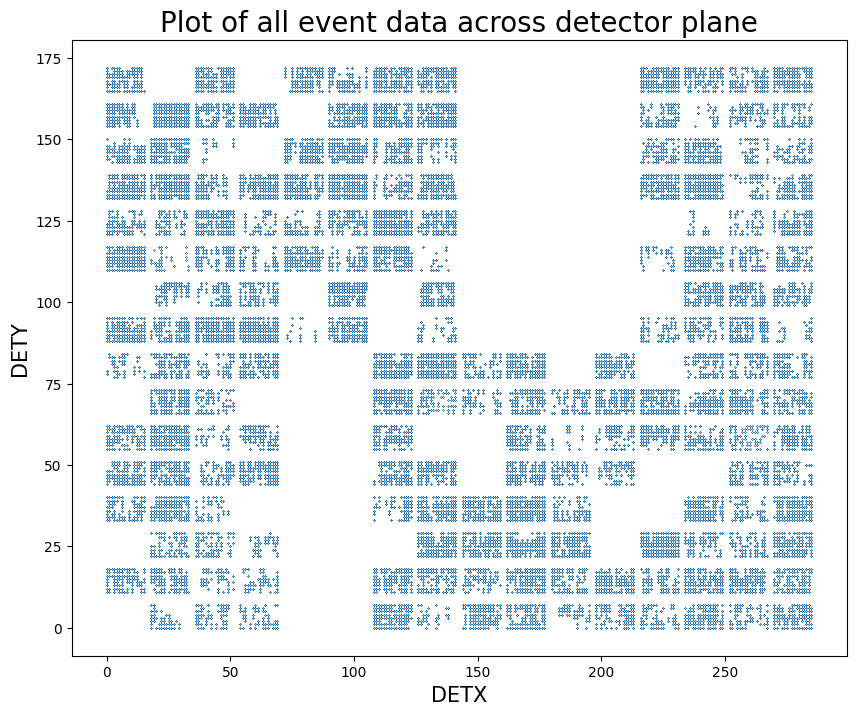

In [39]:
plt.figure(figsize=(10,8))
fig = plt.scatter(ev_data['DETX'], ev_data['DETY'], s=0.0005)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.title("Plot of all event data across detector plane", size=20)
plt.show()

From the same fits file, we can plot the total counts as a function of time throughout the duration of the data. We can see a definite section where we are observing a signal, marked by higher than average peak counts. We can roughly "eyeball" where this section begins and ends. The more "constant" counts surrounding the signal window will make up our background. 

This is in essence how the background fitting works. Instead of evaluating by eye though, the fit is evaluated quantitatively as will be seen later.

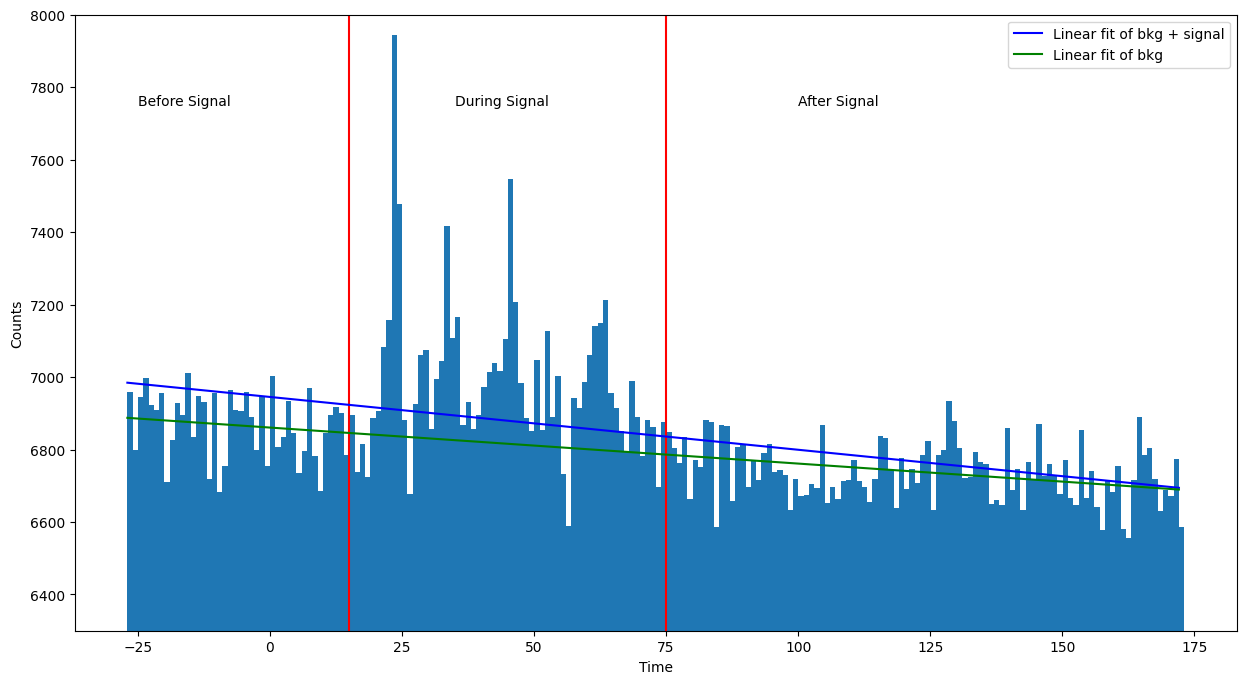

In [40]:
plt.figure(figsize=(15,8))
hist_bin_count, bins, _ = plt.hist(ev_data['TIME'] - 646018360, 200)
ax = plt.gca()
ax.set_ylim([6300, 8000])
plt.xlabel("Time")
plt.ylabel("Counts")

# Plotting vertical lines demarcating different zones within the time window
plt.axvline(x=15, color='r')
plt.axvline(x=75, color='r')

# Adding clarifying text
ax.text(-25, 7750, 'Before Signal')
ax.text(100, 7750, 'After Signal')
ax.text(35, 7750, 'During Signal')

# Plotting linear fit of bkg + signal counts
from scipy.stats import linregress
lin_fit_bkg_sig = linregress(bins[:-1], hist_bin_count)
lin_x = np.linspace(min(bins[:-1]), max(bins[:-1]), 200)
bkg_sig_y = lin_fit_bkg_sig.slope * lin_x + lin_fit_bkg_sig.intercept
plt.plot(lin_x, bkg_sig_y, color='b',label="Linear fit of bkg + signal")


# Plotting linear fit of bkg counts
bkg_bins = bins[:-1]
bkg_bins_loc = np.logical_or(bkg_bins <= 15, bkg_bins >= 75)
bkg_bins = bkg_bins[bkg_bins_loc]
bkg_counts = hist_bin_count[bkg_bins_loc]

lin_fit_bkg = linregress(bkg_bins, bkg_counts)
bkg_y = lin_fit_bkg.slope * lin_x + lin_fit_bkg.intercept
plt.plot(lin_x, bkg_y, color='g',label="Linear fit of bkg")
plt.legend()


Before going through the background fitting process, we have the opportunity to comb through the current data. We can plot the detector plane like before, but colouring each of the detectors according to the number of counts registered. The count sources can be divided into either point sources or diffuse sources. For diffuse sources specifically, the count rates for each detector are proportional to their solid angle exposure to the sky. Thus we would expect the distribution of counts from just the background (which is predominantly made up of diffuse sources) to be similar to the solid angle dpi. 

Here we plot the detector counts for the whole time window so this would include both the signal and background windows that we sectioned off by eye above. 

Note that at around (255,60) and (135,70) we have two regions that are anomalously undercounting in comparison to the neighbouring detector grids. This could very well be due to defective detectors that were not appropriately filtered out from the data.

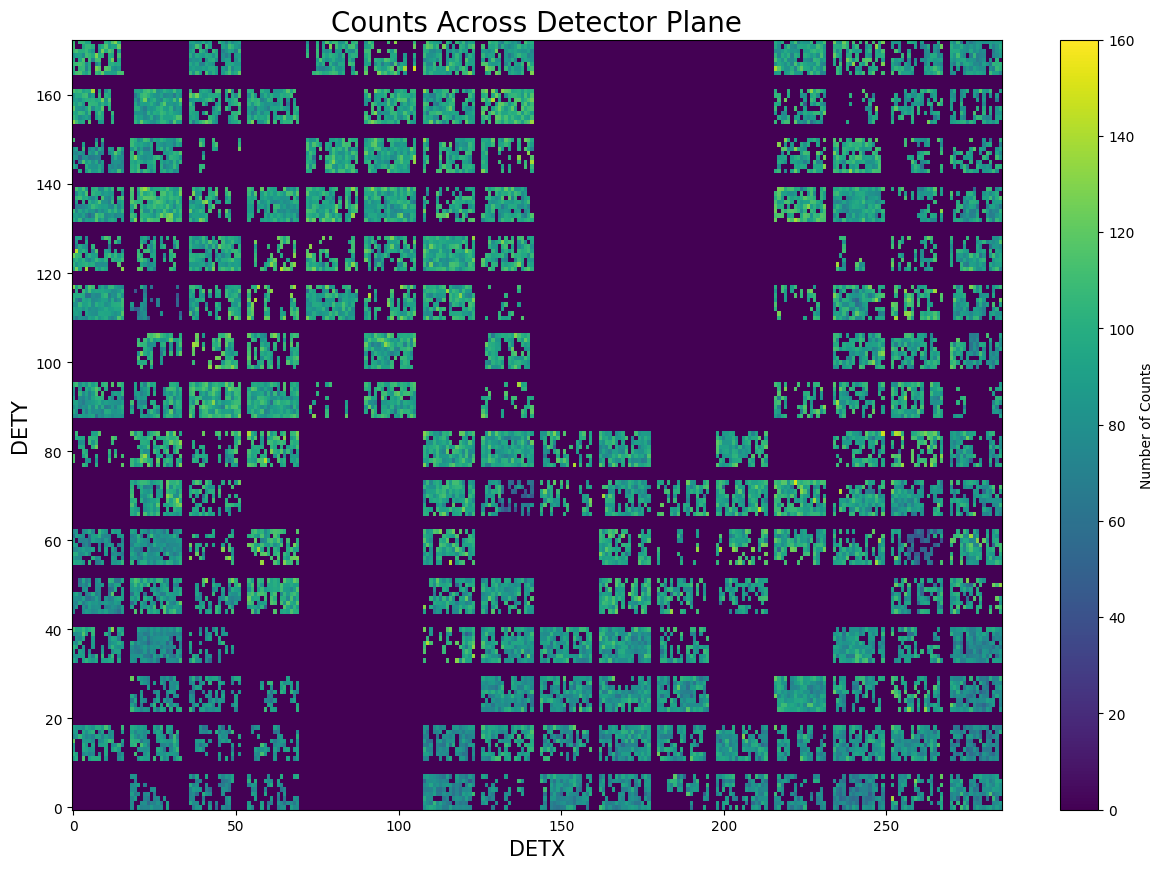

In [41]:
# Trying to show detector count density plot
# need to select only entries of ev_data['DETX'] and ev['DETY'] for which their corresponding TIME is
# within the bounds of the self-imposed signal window.
ev_data
plt.figure(figsize=(15,10))
# Pass bins 
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
plt.hist2d(ev_data['DETX'], ev_data['DETY'], bins=[xbins,ybins], vmin=0, vmax=160,cmin=0)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane", size=20)
plt.show()

[15.00020504 15.00040495 15.00120497 ... 74.99970496 74.99990499
 74.99990499]


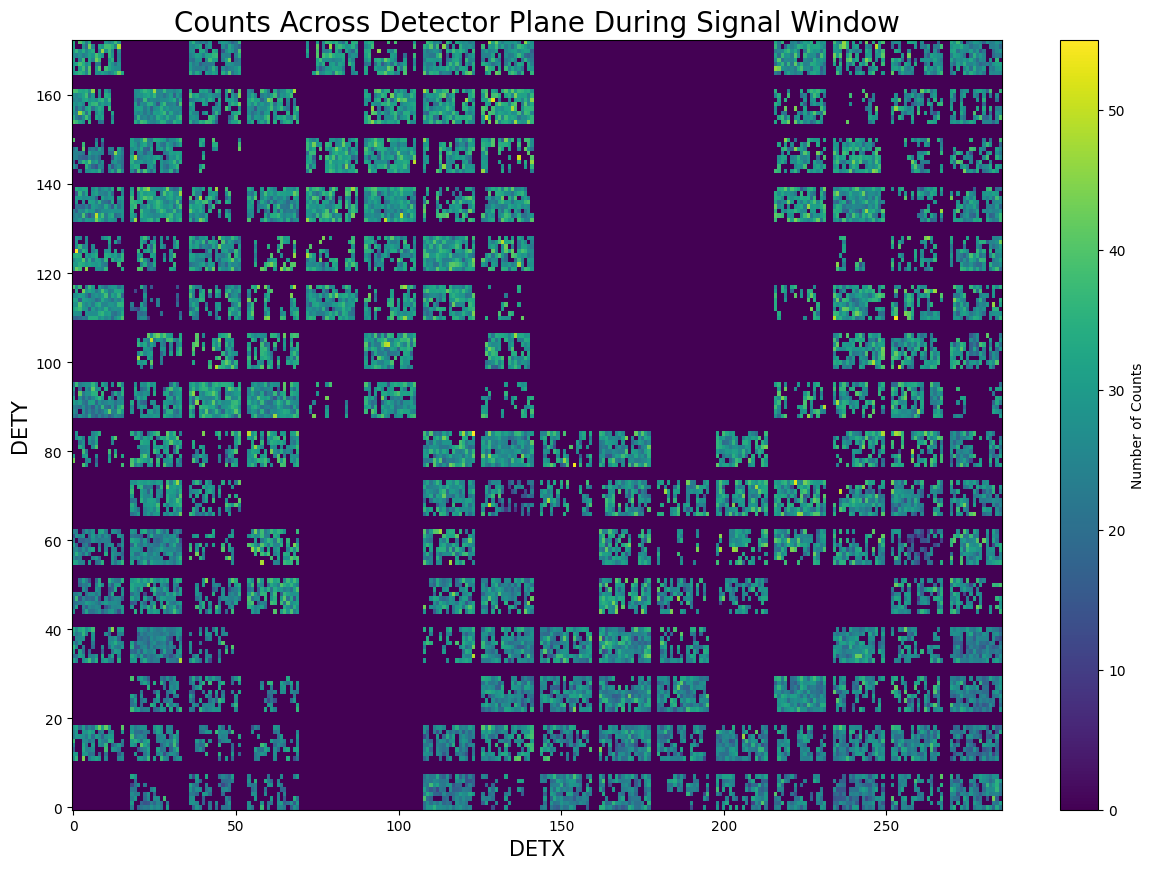

In [42]:
# Compare the count density plots between the makeshift background-only time 
# window and the signal time window. Starting with the signal time window density plot
signal_data = ev_data[np.logical_and((ev_data['TIME'] - 646018360) >= 15, (ev_data['TIME'] - 646018360) <= 75)]
print(signal_data['TIME'] - 646018360)

plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
plt.hist2d(signal_data['DETX'], signal_data['DETY'], bins=[xbins,ybins], cmin=0)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane During Signal Window", size=20)
plt.show()

Even with the makeshift sectioning of the signal and background time windows we can see that within our background window, the count rates bear some familiarity with the solid angle dpi. 

[-26.99969494 -26.99969494 -26.99919498 ... 173.09420502 173.09450495
 173.09520495]


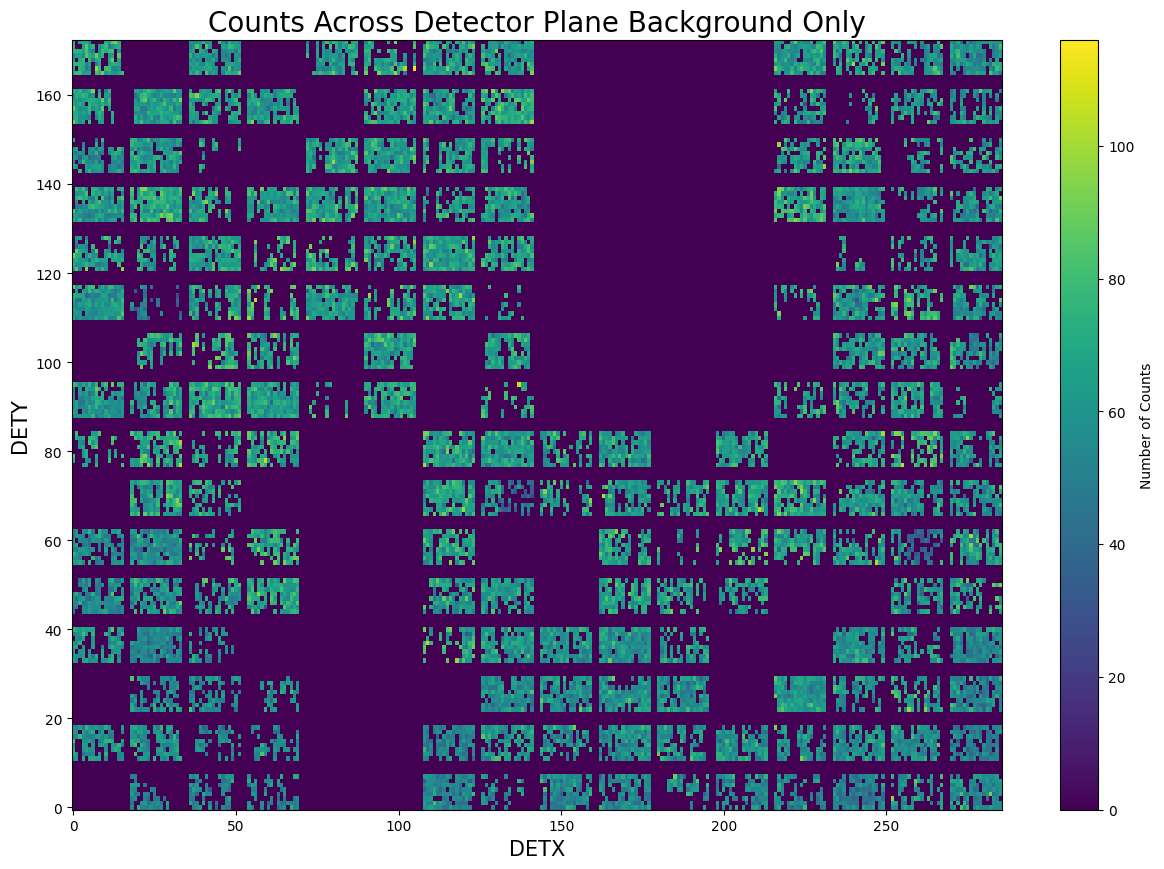

In [43]:
# Compare the count density plots between the makeshift background-only time 
# window and the signal time window. Starting with the signal time window density plot
bkg_data = ev_data[np.logical_or((ev_data['TIME'] - 646018360) <= 15, (ev_data['TIME'] - 646018360) >= 75)]
print(bkg_data['TIME'] - 646018360)

plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
plt.hist2d(bkg_data['DETX'], bkg_data['DETY'], bins=[xbins,ybins], cmin=0)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane Background Only", size=20)
plt.show()

For comparison's sake, we can overlay the grid of detectors on top of the solid angle dpi. Comparing it to the above background-only dpi, we can see how the lower number of counts in the corners of the background-only dpi coincides with areas with lower solid angle exposure in the solid angle dpi.

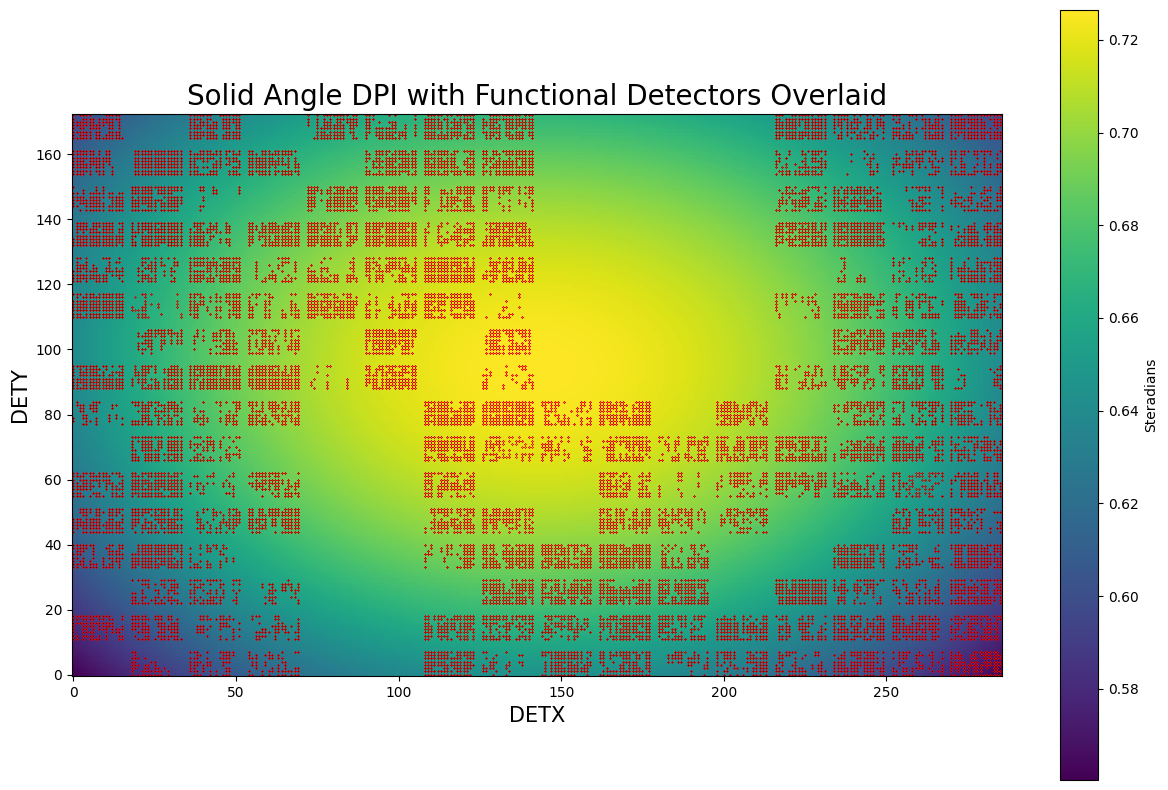

In [44]:
solid_angle_dpi = np.load(solid_angle_dpi_fname)

plt.figure(figsize=(15,10))
plt.imshow(solid_angle_dpi)
plt.colorbar(label="Steradians")
plt.scatter(ev_data['DETX'], ev_data['DETY'], color='r',s=0.0005)
plt.title("Solid Angle DPI with Functional Detectors Overlaid",size=20)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.gca().invert_yaxis()

We can additionally segment the event data between counts from high energy and low energy detections. At high enough energies, particles are able to bypass any of the craft's shielding and lead masks, resulting in a flatter distribution of counts. Our anticipation with separating the events this way is that low energy (<64keV) counts will be distributed according to the solid angle dpi while high energy (>64keV) will be more uniformly distributed.

In [45]:
# Compare the count density plots between <=50keV and >50keV. Starting with the signal 
# time window density plot
low_energy_data = ev_data[ev_data['ENERGY'] <= 64]
low_energy_data

FITS_rec([(6.46018333e+08,  1346, 0, 2685, 0.0000000e+00,  25, 134, 252, 25.2, 0),
          (6.46018333e+08, 14333, 0, 2699, 5.1307690e-04, 234, 104, 229, 22.9, 0),
          (6.46018333e+08, 18679, 0, 2420, 0.0000000e+00,  68,   0, 562, 56.2, 0),
          ...,
          (6.46018533e+08, 27912, 0, 2509, 0.0000000e+00, 181,  33, 265, 26.5, 0),
          (6.46018533e+08, 28317, 0, 2624, 0.0000000e+00, 183,  49, 208, 20.8, 0),
          (6.46018533e+08, 12353, 0, 2462, 8.8046494e-05, 223, 155, 621, 62.1, 0)],
         dtype=(numpy.record, [('TIME', '>f8'), ('DET_ID', '>i2'), ('EVENT_FLAGS', 'u1'), ('PHA', '>i2'), ('MASK_WEIGHT', '>f4'), ('DETX', '>i2'), ('DETY', '>i2'), ('PI', '>i2'), ('ENERGY', '>f8'), ('SLEW', '>i8')]))

In [46]:
high_energy_data = ev_data[np.logical_and(ev_data['ENERGY'] > 64,ev_data['ENERGY'] < 350)]
high_energy_data

FITS_rec([(6.46018333e+08, 30278, 0, 1377,  0.        , 224,  56, 3098, 309.8, 0),
          (6.46018333e+08, 29237, 0, 2327,  0.        , 240,  60,  829,  82.9, 0),
          (6.46018333e+08, 12458, 0, 1943, -0.00049794, 226, 170, 1749, 174.9, 0),
          ...,
          (6.46018533e+08, 24511, 0, 2347,  0.        , 115,  73,  878,  87.8, 0),
          (6.46018533e+08, 14227, 0, 1744,  0.00059491, 247, 103, 2004, 200.4, 0),
          (6.46018533e+08, 23871, 0, 2287,  0.        , 115,  40,  923,  92.3, 0)],
         dtype=(numpy.record, [('TIME', '>f8'), ('DET_ID', '>i2'), ('EVENT_FLAGS', 'u1'), ('PHA', '>i2'), ('MASK_WEIGHT', '>f4'), ('DETX', '>i2'), ('DETY', '>i2'), ('PI', '>i2'), ('ENERGY', '>f8'), ('SLEW', '>i8')]))

Indeed, as we plot the respective data, we can see that lower energy counts are similarly distributed according to the solid angle dpi. For high energies, we can see that counts are broadly uniform across the detector plane. There are natural variances in the number of counts in some detectors, with some counting up to 50+ detections. Overall, though, the high energy counts are uniformly distributed.

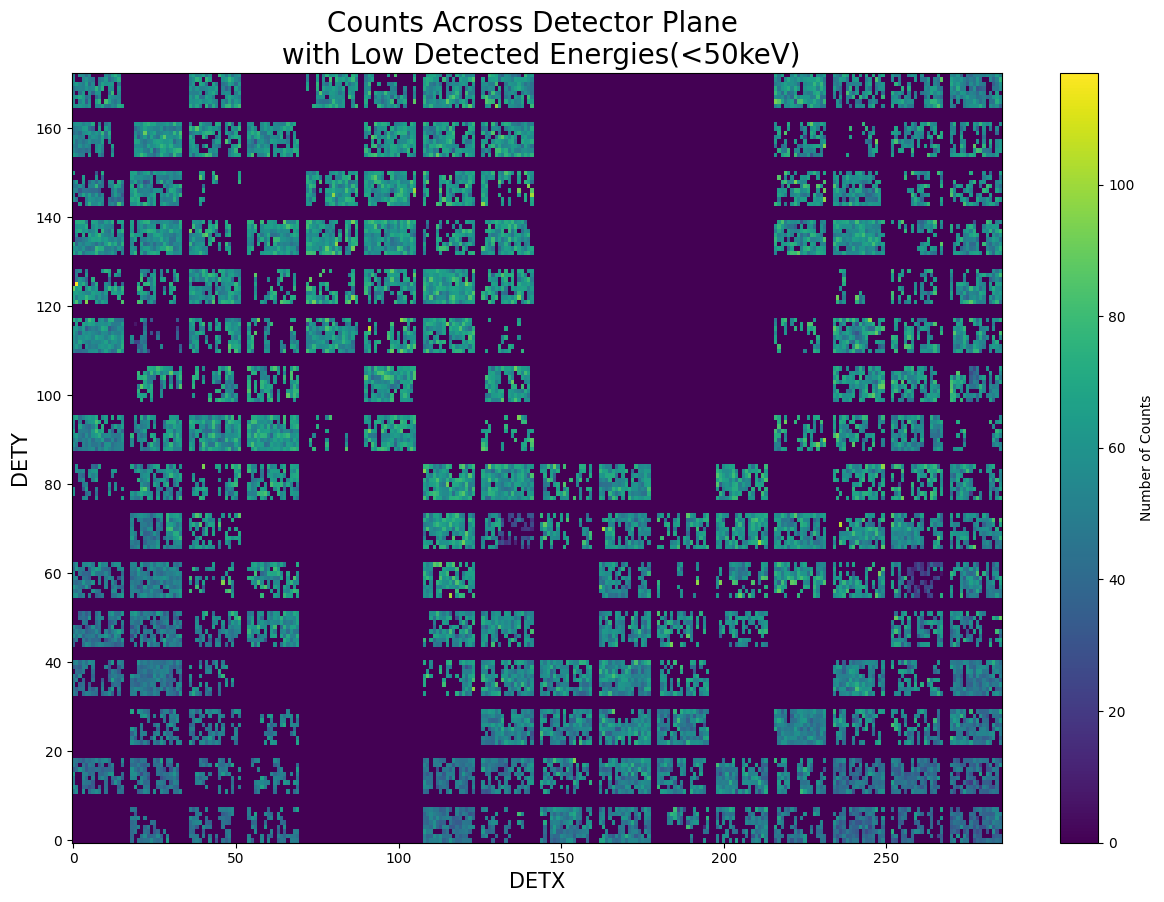

In [47]:
plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
plt.hist2d(low_energy_data['DETX'], low_energy_data['DETY'], bins=[xbins,ybins], cmin=0)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane \n with Low Detected Energies(<50keV)", size=20)
plt.show()

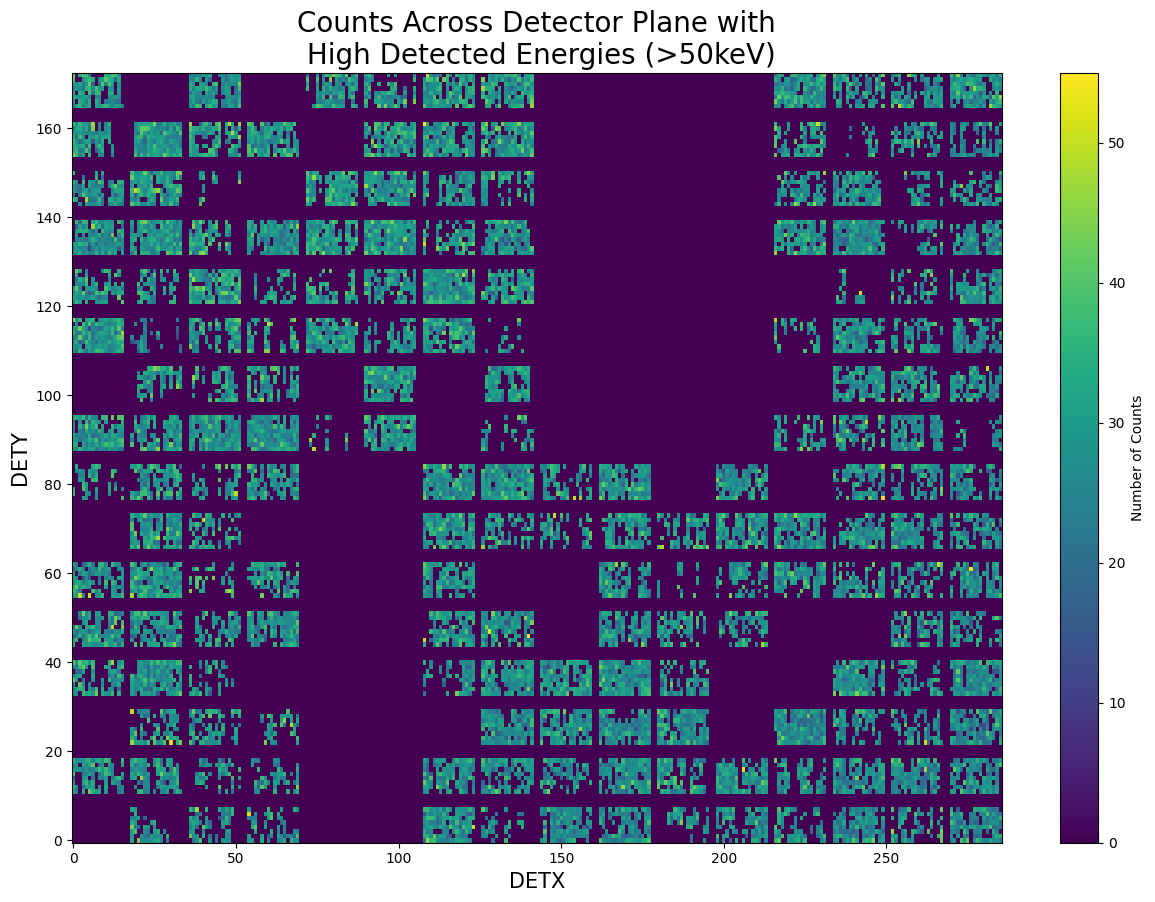

In [48]:
plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
plt.hist2d(high_energy_data['DETX'], high_energy_data['DETY'], bins=[xbins,ybins], cmin=0)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane with\n High Detected Energies (>50keV)", size=20)
plt.show()

### **do_bkg_estimation_wPSs_mp2.py**
___

We now go through the background fitting process from do_bkg_estimation_wPSs_mp2.py. 

In [49]:
# Now going over the main() for do_bkg_estimation_wPSs_mp2.py and seeing the 
# background fitting process step-by-step
attfile = fits.open(os.path.join(work_dir,'attitude.fits'))[1].data
dmask = fits.open(os.path.join(work_dir,'detmask.fits'))[0].data
attfile

FITS_rec([(6.46000922e+08, [ 0.70613949, -0.58084469, -0.40184175,  0.05009672], [270.15215232, -30.61826799, 218.65690613], 1),
          (6.46000923e+08, [ 0.70614058, -0.58084337, -0.40184182,  0.05009609], [270.15234872, -30.61838986, 218.65681458], 1),
          (6.46000924e+08, [ 0.70616164, -0.58083113, -0.4018256 ,  0.05007119], [270.15598075, -30.62000045, 218.65231323], 1),
          ...,
          (6.46043530e+08, [-0.31367327, -0.53680109, -0.78323223,  0.00096847], [157.34551202,  29.49830241, 285.11172485], 1),
          (6.46043535e+08, [-0.3136725 , -0.53680366, -0.78323078,  0.00097094], [157.34572342,  29.49833859, 285.11141968], 1),
          (6.46043540e+08, [-0.31367247, -0.53680369, -0.78323077,  0.00097115], [157.34574487,  29.49834958, 285.11141968], 1)],
         dtype=(numpy.record, [('TIME', '>f8'), ('QPARAM', '>f8', (4,)), ('POINTING', '>f8', (3,)), ('SOURCE', 'u1')]))

In [50]:
ndets = np.sum(dmask==0)
ndets

14932

In [51]:
try:
    GTI = Table.read(evfname, hdu='GTI_POINTING')
    print("Found GTI_POINTING events")
except:
    GTI = Table.read(evfname, hdu='GTI')
    print("Did not find GTI_POINTING events")
GTI


Found GTI_POINTING events


<Table length=1>
   START         STOP     
     s            s       
  float64      float64    
----------- --------------
646018333.0 646018533.0953

In [52]:

gti_bl = (GTI['STOP']>(trigtime-2e3))&(GTI['START']<(trigtime+2e3))
gti_bl

array([ True])

In [53]:
tot_exp = 0.0
for row in GTI:
    tot_exp += (row['STOP'] - row['START'])
tot_exp

200.09529995918274

In [54]:
tmin = GTI['START'][0]
tmax = GTI['STOP'][-1]
tmids = (GTI['START']+GTI['STOP'])/2.
tmid = tmids[np.argmin(np.abs(tmids - trigtime))]

print("tmin = ", tmin)
print("tmax = ", tmax)
print("tmid = ", tmid)

tmin =  646018333.0
tmax =  646018533.0953
tmid =  646018433.04765


In our background fitting process, we will perform an initial fit using all of the TTE data outside of a signal time window. This signal time window is defined below with asymmetric bounds -10s and +20s about the trigger time. 

In [55]:
sig_dtwind = (-10*1.024, 20*1.024)
sig_twind = (trigtime + sig_dtwind[0], trigtime + sig_dtwind[1])

print(sig_twind)

(646018372.9387, 646018403.6587)


In [56]:
ebins0 = np.array([15.0, 24.0, 35.0, 48.0, 64.0])
ebins0 = np.append(ebins0, np.logspace(np.log10(84.0), np.log10(500.0), 5+1))[:-1]
ebins0 = np.round(ebins0, decimals=1)[:-1]
ebins1 = np.append(ebins0[1:], [350.0])
nebins = len(ebins0)

Before the initial background fit, we must first check for any bright, point sources that may be in the FOV of the craft. Such point sources are bright enough to contribute a large number of counts within short time frames and need to be accounted for in the background model. 

The sources are compiled into a table by the function get_srcs_infov(). The function consults a table of all known, bright sources and compares their (imx,imy) coordinates with a range of (imx,imy) coordinates that represent the FOV of the craft itself. This FOV is defined as |imx| < 1.75 and |imy| < 0.95. Thus, any source within this rectangular grid of (imx,imy) coordinates is added into the table of sources. 

The plot below represents the instrument view of the sky and the locations of all of the bright sources in this view. 

Text(1.8, 0.75, 'Outside \n FOV')

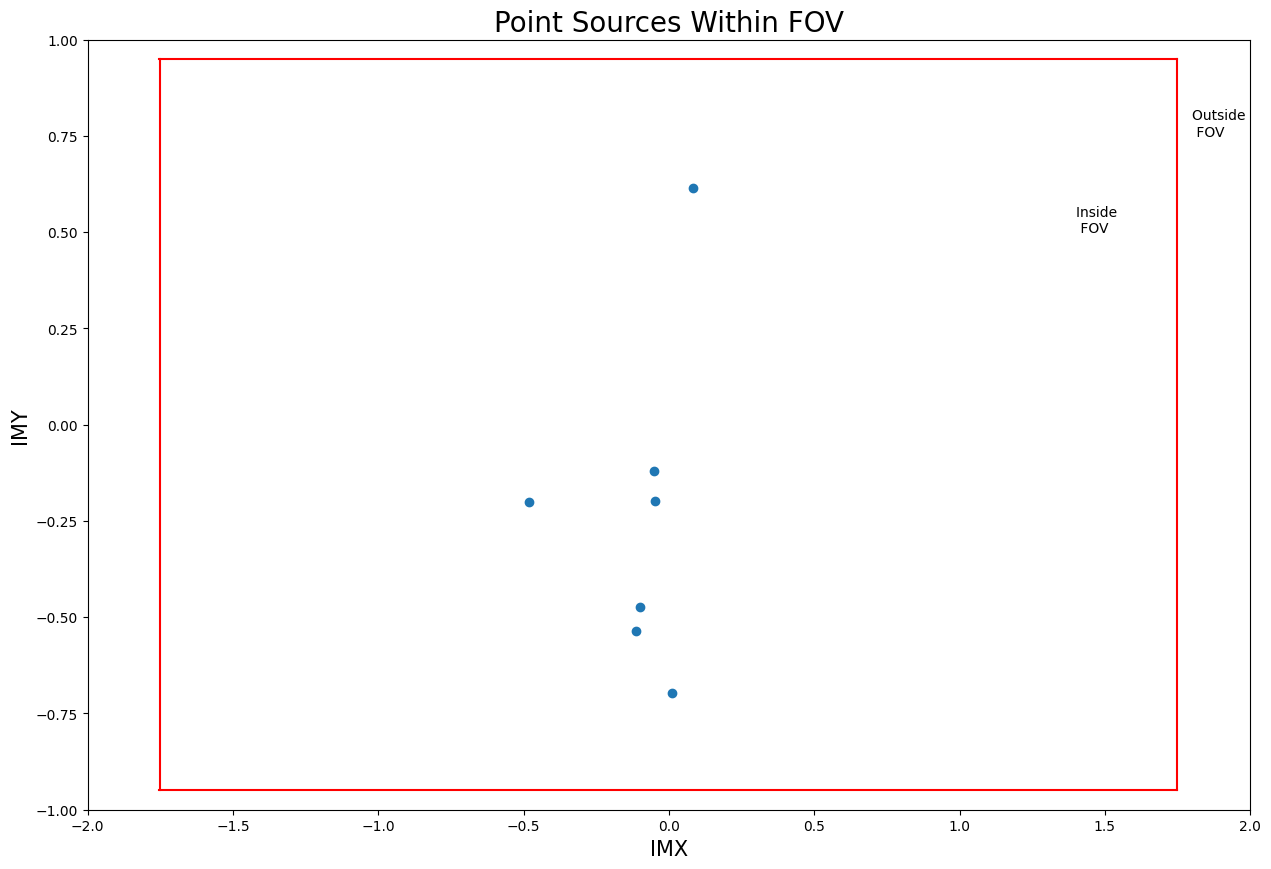

In [57]:
# Finding all sources within the FOV
src_tab = get_srcs_infov(attfile, tmid)
Nsrcs = len(src_tab)

plt.figure(figsize=(15,10))
plt.scatter(src_tab['imx'], src_tab['imy'])
plt.title("Point Sources Within FOV",size=20)
plt.xlabel("IMX", size=15)
plt.ylabel("IMY", size=15)
plt.xlim((-2.0, 2.0))
plt.ylim((-1.0, 1.0))

plt.axvline(1.75, ymin=0.025, ymax=0.975, color='r')
plt.axvline(-1.75, ymin=0.025,ymax=0.975, color='r')
plt.axhline(-0.95, xmin=0.061, xmax=0.937, color='r')
plt.axhline(0.95, xmin=0.061, xmax=0.937,color='r')

ax = plt.gca()
ax.text(1.4, 0.5, 'Inside \n FOV', size=10)
ax.text(1.8, 0.75, 'Outside \n FOV', size=10)

In [58]:
bl_dmask = (dmask==0.)
bkg_mod = Bkg_Model_wFlatA(bl_dmask, solid_angle_dpi, nebins, use_deriv=True)
llh_obj = LLH_webins(ev_data, ebins0, ebins1, bl_dmask)

For context, a row entry in the source table will look like the following:

In [59]:
src_tab = src_tab[:1]
Nsrcs = 1
print(src_tab)

  Name  RAJ2000_1 DEJ2000_1 ...         imx                 imy         
           deg       deg    ...                                         
------- --------- --------- ... ------------------- --------------------
Sco X-1   244.979    -15.64 ... -0.4801726284172064 -0.20015462768783537


With the bright sources all accounted for, we can perform our initial fit. In the case of no bright sources present, our initial background fit parameters will be taken from the background model defined above by bkg_mod. Otherwise, we call upon do_init_bkg_wPSs to perform an initial fit on the background model with point source models added for each of the point sources in the FOV. 

Within do_init_bkg_wPSs, we call upon another background fitting function, bkg_withPS_fit. For this function, we create a grid of displacements in imx and imy coordinates to apply to the imx and imy coordinates of the point sources. Despite knowing the precise location that the point source should lie in the image coordinates, for the purposes of acquiring the best fit, we check to see if the fit is improved by adjusting each PS's coordinates. The result is a calculation of the background negative log likelihood and parameters. Also provided are the TS_nulls which are the calculations for the negative log likelihood for when the parameters for each of the point sources are set to zero.

At the completion of bkg_withPS_fit, we return back to the original function with bf_nllh, bf_params, and TS_nulls. Point sources are checked to see if they are significantly detected according to the following inequality:
$$\sqrt{2\Delta LLH } < 7$$
Sources for which the above expression is larger than 7 are considered significantly detected and are retained in our compound background + point source model. Otherwise, the point sources are excluded from our background model. 

The result of the fitting process is a dictionary of parameters for the background rates, flat rates for the background model, and the binned rates for the all of the sources (as well as their imx and imy coordinates). The meaning for each type of rate is explained in Example_LLH_setup_fixed_dirs.ipynb.


In [60]:
if Nsrcs > 0:

    rt_dir = os.path.join(NITRATES_path,'ray_traces_detapp_npy')
    print(rt_dir)
    rt_obj = RayTraces(rt_dir)
    
    Nprocs = 1
    if Nsrcs > 1:
        Nprocs = 4

    tmin_ = trigtime-5e2
    tmax_ = trigtime+5e2
    
    print("Beginning initial bkg fit")
    init_bf_params, src_tab = do_init_bkg_wPSs(bkg_mod, llh_obj, src_tab, rt_obj,\
                                                    GTI, sig_twind, Nprocs=Nprocs,\
                                                    tmin=tmin_, tmax=tmax_)

    Nsrcs = len(src_tab)
    Nsrcs = 1
    # Now need to do each time, with these PSs and these imxys

else:
    init_bf_params = {k:bkg_mod.param_dict[k]['val'] for k in bkg_mod.param_names}

print(init_bf_params)

/Volumes/WD/Development/Programming/NITRATES_RESP_DIR_PIP/ray_traces_detapp_npy
Beginning initial bkg fit
{'Background_bkg_rate_0': 0.0942853230504335, 'Background_bkg_rate_1': 0.0678476442615112, 'Background_bkg_rate_2': 0.040626679414432744, 'Background_bkg_rate_3': 0.03961569692430292, 'Background_bkg_rate_4': 0.03462621642264448, 'Background_bkg_rate_5': 0.034789805238802624, 'Background_bkg_rate_6': 0.03298230765871578, 'Background_bkg_rate_7': 0.02470351249187846, 'Background_bkg_rate_8': 0.01767786744729647, 'Background_flat_0': 0.0, 'Background_flat_1': 0.0, 'Background_flat_2': 0.08577117667504995, 'Background_flat_3': 0.025932603405302564, 'Background_flat_4': 0.2732185899616832, 'Background_flat_5': 0.7322148026995329, 'Background_flat_6': 0.8082042255814617, 'Background_flat_7': 1.0, 'Background_flat_8': 1.0, 'Sco X-1_imx': -0.4801726284172064, 'Sco X-1_imy': -0.20015462768783537, 'Sco X-1_rate_0': 0.05271224008426154, 'Sco X-1_rate_1': 0.007533949179369819, 'Sco X-1_rate_2

We tidy things up for the eventual final fit by creating a compound model that includes the background model and the remaining point source models for each of the significantly detected point sources. We also compile a list of fixed parameters that include any of the background flat rate parameters and imx and imy coordinates.

Again, for no point sources in the POV, we just take our compound model to be the background model.

In [61]:
if Nsrcs > 0:
    fixed_pars = [pname for pname in list(init_bf_params.keys()) if '_flat_' in pname\
                or '_imx' in pname or '_imy' in pname]
    mod_list = [bkg_mod]
    ps_mods = []
    for i in range(Nsrcs):
        row = src_tab[i]
        mod = Point_Source_Model_Binned_Rates(row['imx'], row['imy'], 0.1,\
                                              [ebins0,ebins1], rt_obj, bl_dmask,\
                                                  use_deriv=True, name=row['Name'])
        ps_mods.append(mod)

    mod_list += ps_mods
    mod = CompoundModel(mod_list)

else:
    init_bf_params = {k:bkg_mod.param_dict[k]['val'] for k in bkg_mod.param_names}
    mod = bkg_mod
    fixed_pars = []




Because we are not actually aware of the precise time of the signal, we perform our final background fitting procedure over a search window. The search window is divided into time windows where the final fit is performed for each window. At each time window, we remove +-10 seconds of the central TTE data in case it encapsulates the actual signal. Then, assuming we have selected the correct time window, the remaining data in the time window contains just the background and can best be used to fit our background model. 

The arrangement of the time windows are given by **t_ax** which uses the interval spacing defined by **dt_ax**. To be clear, **t_ax** itself does not represent the time windows but the arrangement of the midpoints for each time window. The time step between each time window is given by **bkg_tstep**. 

In [62]:
bkg_dur = 60.0*1.024
twind = 20*1.024
bkg_tstep = 1*1.024
sig_wind = 20*1.024

# Setting up time windows for repeating final fits. These represent the middle
# time positions from which we will repeat our final fits. The increments in 
# the time windows is supposed to be 1.024. Time windows will contain data +-40
# seconds from the centre time with +- 10s from the centre time removed.
dt_ax = np.arange(-twind, twind+1, bkg_tstep)
t_ax = dt_ax + trigtime - 646018360
Ntpnts = len(dt_ax)
bkg_bf_dicts = []


The time windows themselves are defined first by designating the midpoint **tmid** which is taken from **t_ax**. The signal time window is constructed around this midpoint as defined by **sig_wind** which will be added to our good time intervals. We also add the bad time intervals which extend from **bkg_t1** to -inf and **bkg_t0** to +inf. 

The following graphs show how the time intervals are laid out about the trigger time and the arrangement of the gtis and btis for a given **tmid** index.

In [63]:
def print_bkg_fit_timestep(i):
    # First plot
    tmid = t_ax[i]
    sig_twind = (-sig_wind/4. + tmid, 3.*sig_wind/4. + tmid)
    gti_ = add_bti2gti(sig_twind, GTI)
    bkg_t0 = tmid - sig_wind/4. - bkg_dur/2.
    bkg_t1 = tmid + 3.*sig_wind/4. + bkg_dur/2.
    bkg_bti = Table(data=([-np.inf, bkg_t1], [bkg_t0, np.inf]), names=('START', 'STOP'))
    gti_ = add_bti2gti(bkg_bti, gti_)

    plt.figure(figsize=(15,10))
    hist_bin_count, bins, _ = plt.hist(ev_data['TIME']-646018360, 200)
    ax = plt.gca()
    ax.set_ylim([6300, 8250])
    plt.xlabel("Time (s)",size=15)
    plt.ylabel("Counts",size=15)

    # Plotting vertical lines demarcating different zones within the time window
    for t in t_ax[:-1]:
        plt.axvline(t, color='r', alpha=0.3)
    plt.axvline(t_ax[-1], color='r', alpha=0.3, label = "t_ax time windows")
    plt.axvline(trigtime-646018360, color='g', label = 'Trigger Time')
    plt.axvline(tmid, color='y', alpha=1.0, label = "Current tmid")
    plt.legend()
    plt.title("Location of trigger time and current tmid", size=20)





    # Second plot

    tmid = t_ax[i]
    #sig_twind = (-sig_wind/2. + tmid, sig_wind/2. + tmid)
    sig_twind = (-sig_wind/4. + tmid, 3.*sig_wind/4. + tmid)
    gti_ = add_bti2gti(sig_twind, GTI)
    bkg_t0 = tmid - sig_wind/4. - bkg_dur/2.
    bkg_t1 = tmid + 3.*sig_wind/4. + bkg_dur/2.
    bkg_bti = Table(data=([-np.inf, bkg_t1], [bkg_t0, np.inf]), names=('START', 'STOP'))
    gti_ = add_bti2gti(bkg_bti, gti_)

    plt.figure(figsize=(15,10))
    hist_bin_count, bins, _ = plt.hist(ev_data['TIME']-646018360, 200)
    ax = plt.gca()
    ax.set_ylim([6300, 8250])
    plt.xlabel("Time (s)",size=15)
    plt.ylabel("Counts",size=15)

    # Plotting vertical lines demarcating different zones within the time window
    for t in t_ax:
        plt.axvline(t, color='r', alpha=0.3)

    plt.axvline(trigtime-646018360, color='g')
    plt.axvline(sig_twind[0], color='b')
    plt.axvline(sig_twind[1], color='b')
    plt.axvline(tmid, color='y')
    ax.text(sig_twind[0]-27, 8000, "sig_twind[0]",size=15)
    ax.text(sig_twind[1], 8000, "sig_twind[1]",size=15)
    plt.axvspan(sig_twind[0], sig_twind[1], color='b', alpha = 0.2, label="signal time window")
    plt.axvspan(bkg_t1, ax.get_xlim()[1], color='g', alpha = 0.2, label="bad time interval")
    plt.axvspan(bkg_t0, ax.get_xlim()[0], color='g', alpha = 0.2)
    plt.legend()

    plt.axvline(bkg_t0, color='g')
    plt.axvline(bkg_t1, color='g')
    ax.text(bkg_t0-15, 8100, "bkg_t0",size=15)
    ax.text(bkg_t1, 8100, "bkg_t1",size=15)
    plt.title("Signal time window for tmid = {c}".format(c=tmid), size=20)
    

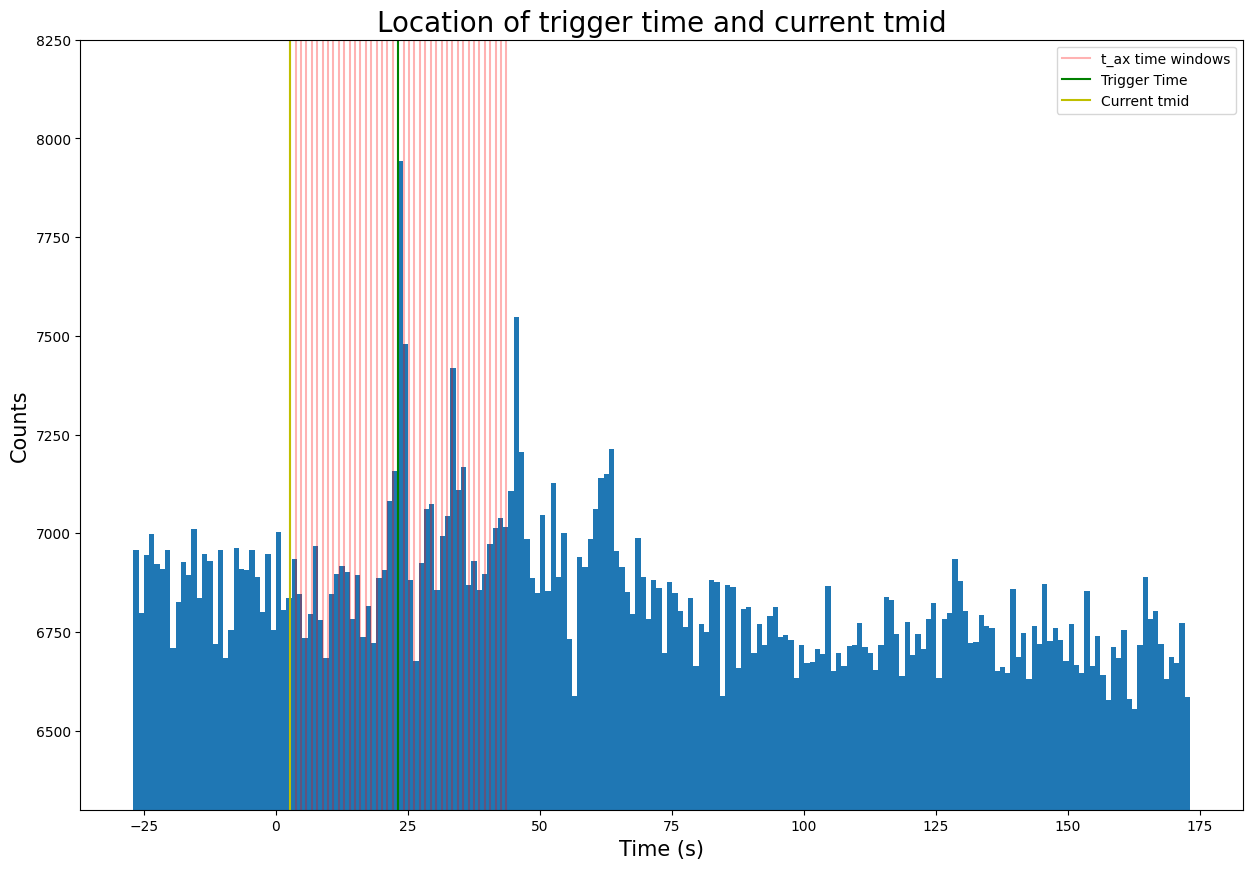

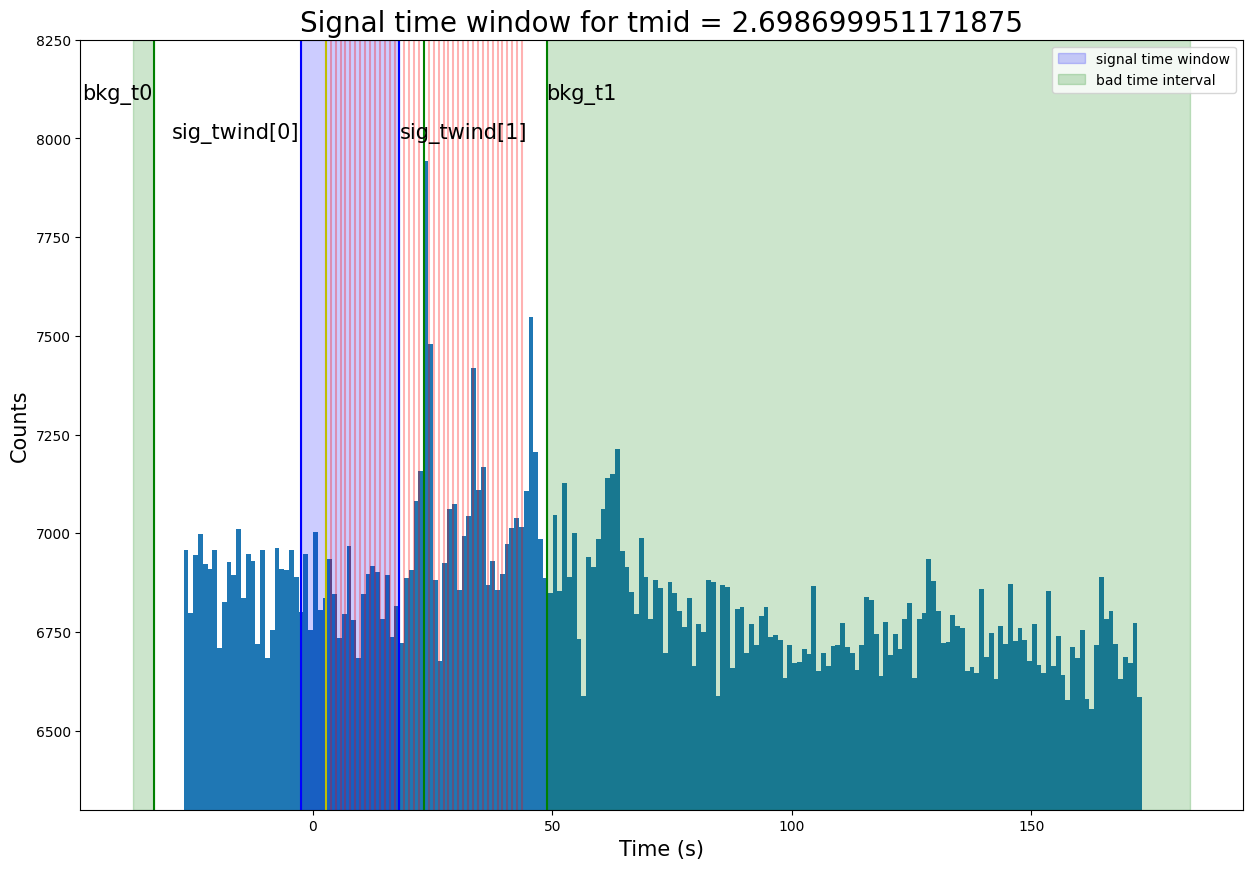

In [64]:
# Printing the 0th timestep in the background fitting loop
print_bkg_fit_timestep(0)

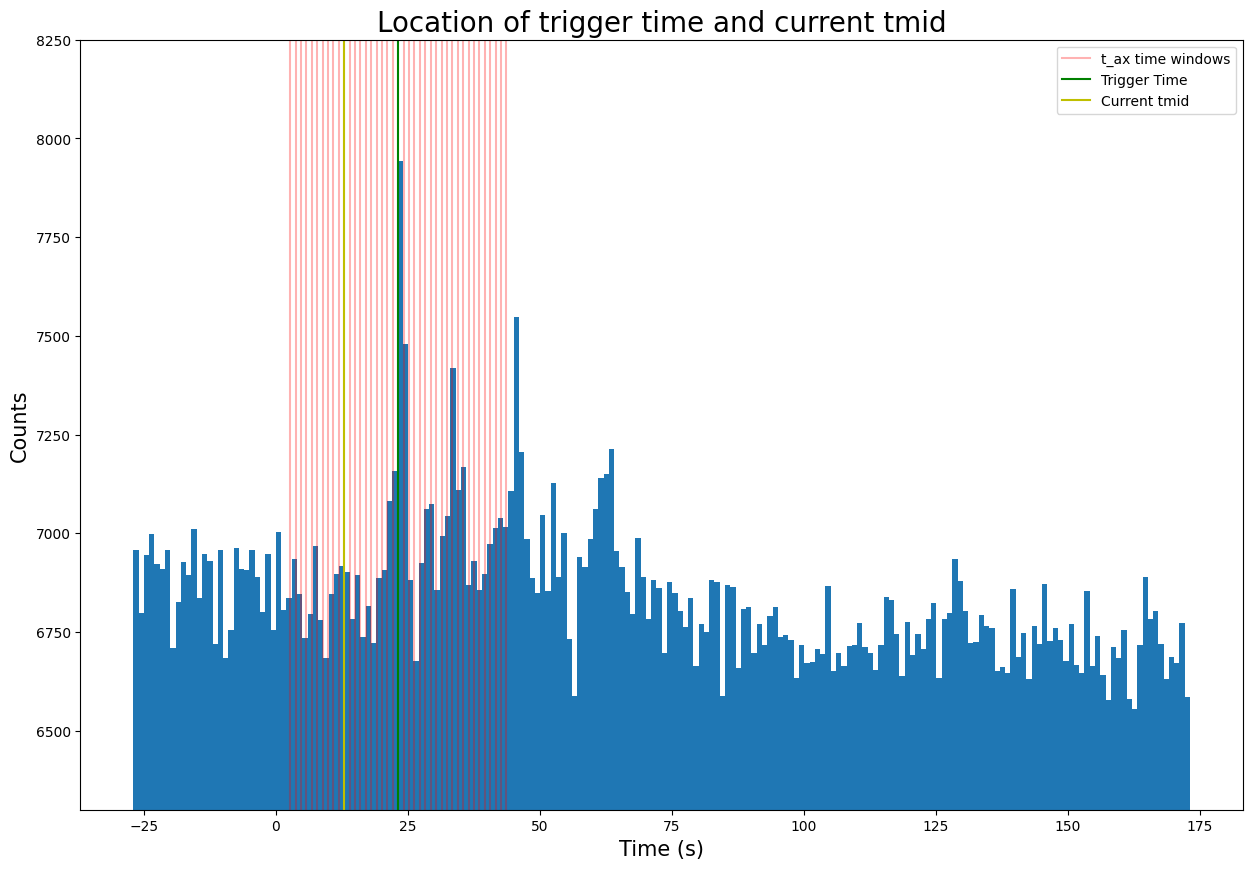

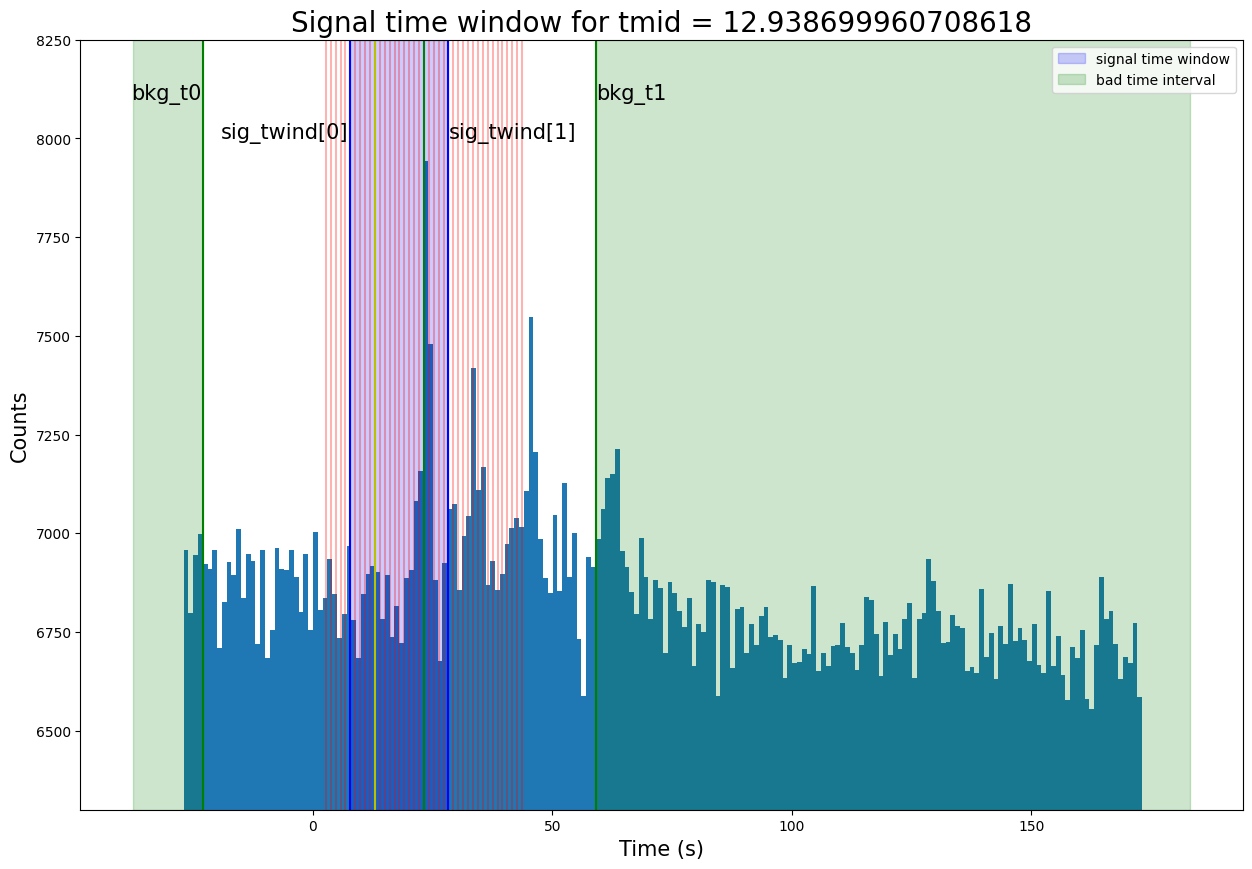

In [65]:
# Printing the 10th timestep
print_bkg_fit_timestep(10)

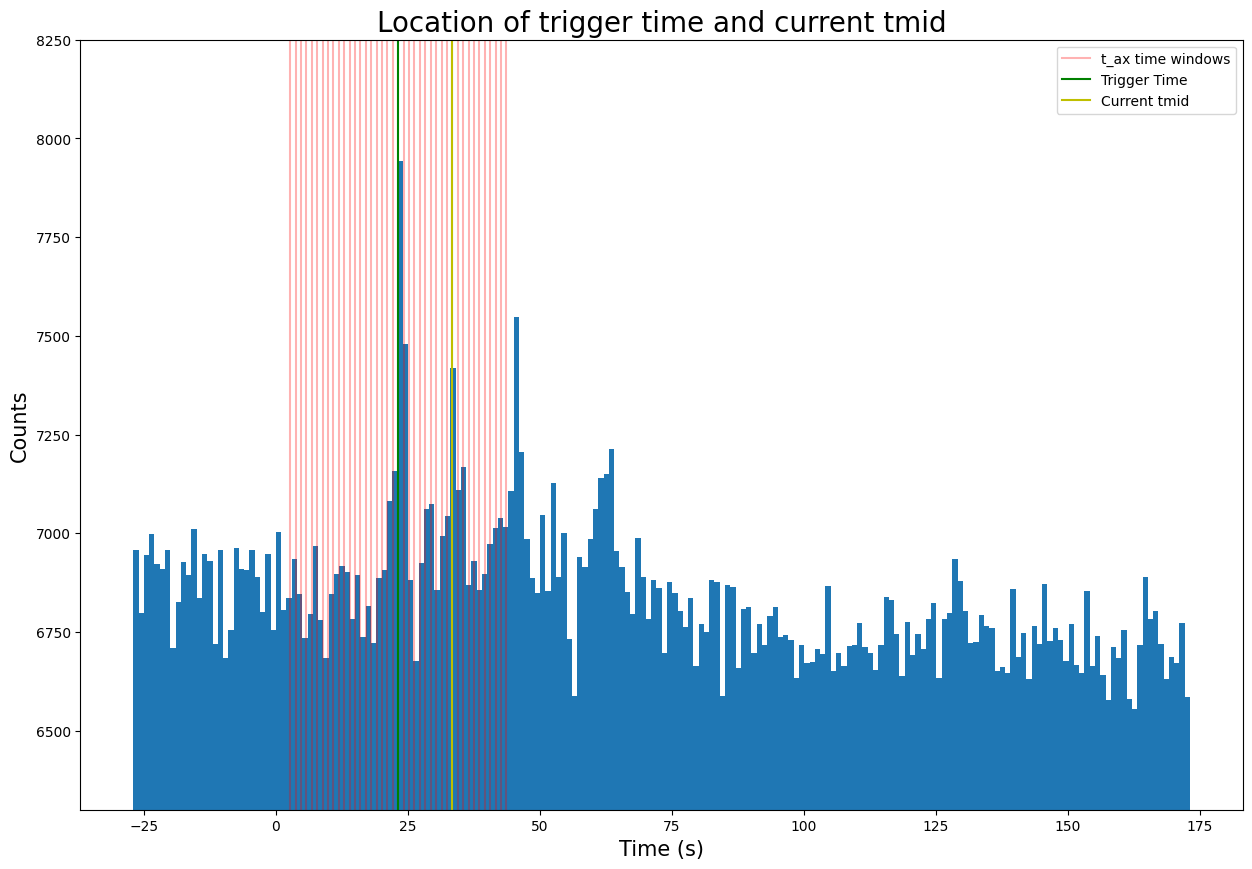

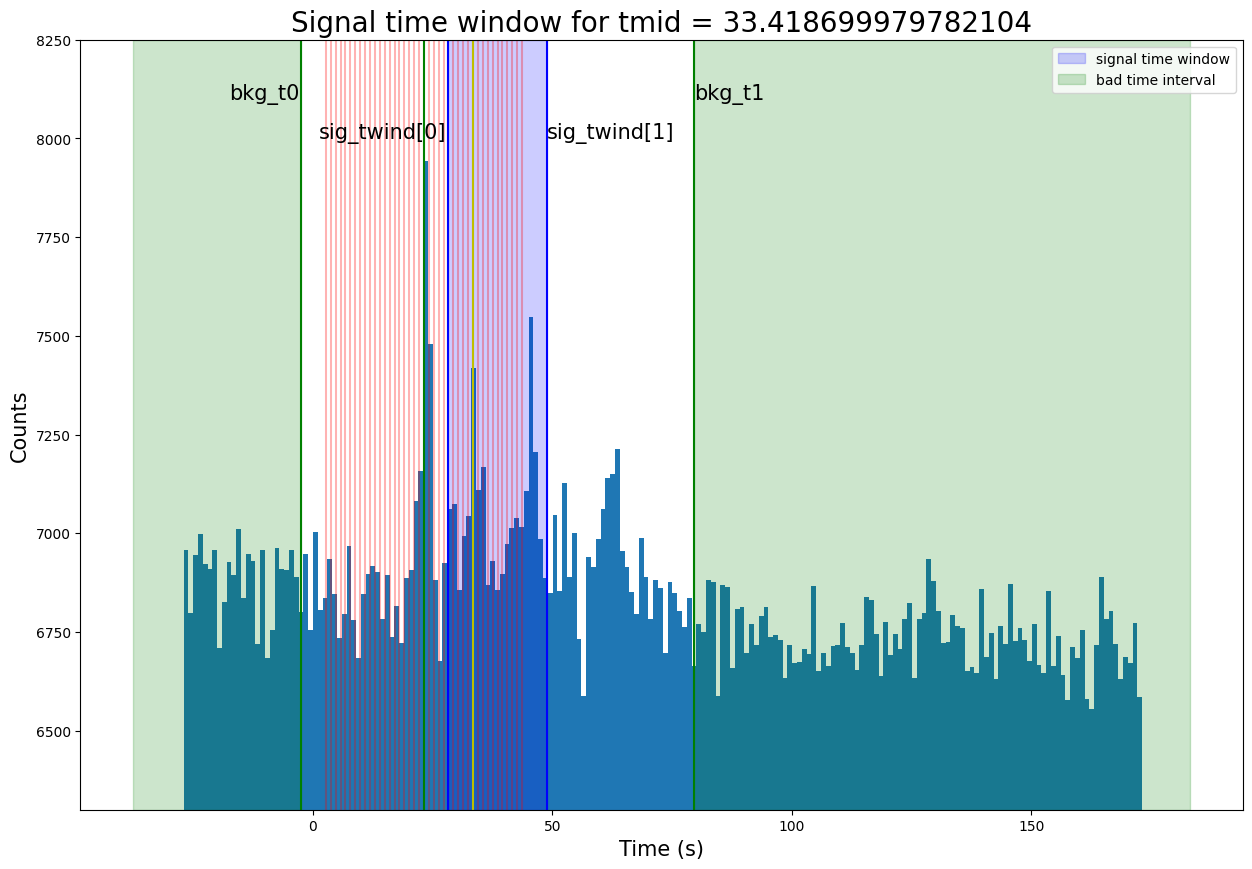

In [66]:
# Printing the 30th timestep
print_bkg_fit_timestep(30)

With that visualization out of the way, we can do the final fits across all of the time windows, **t_ax**. Provided that the total exposure is at least 10.0s we can do a final fit on the time interval by calling the function bkg_withPS_fit_fiximxy. For each call, we update a dictionary of parameters with the results of the final fit (most noteably the calculated nllh) and add the dictionary to a list of background fit parameters.

In [67]:
for i in range(Ntpnts):

    tmid = t_ax[i]+646018360
    sig_twind = (-sig_wind/2. + tmid, sig_wind/2. + tmid)
    sig_twind = (-sig_wind/4. + tmid, 3.*sig_wind/4. + tmid)
    gti_ = add_bti2gti(sig_twind, GTI)
    # bkg_t0 = tmid - sig_wind/2. - bkg_dur/2.
    # bkg_t1 = tmid + sig_wind/2. + bkg_dur/2.
    bkg_t0 = tmid - sig_wind/4. - bkg_dur/2.
    bkg_t1 = tmid + 3.*sig_wind/4. + bkg_dur/2.
    bkg_bti = Table(data=([-np.inf, bkg_t1], [bkg_t0, np.inf]), names=('START', 'STOP'))
    gti_ = add_bti2gti(bkg_bti, gti_)
    print(tmid - trigtime)
    print(gti_)
    t0s = gti_['START']
    t1s = gti_['STOP']
    exp = 0.0
    for ii in range(len(t0s)):
        exp += (t1s[ii] - t0s[ii])
    if exp < 10.0:
        continue

    nllh, params, errs_dict, corrs_dict = bkg_withPS_fit_fiximxy(src_tab, mod, llh_obj, t0s, t1s,\
                                                                     copy(init_bf_params),\
                                                                     fixed_pnames=fixed_pars)

    params.update(errs_dict)
    params.update(corrs_dict)
    params['nllh'] = nllh
    params['time'] = tmid
    params['dt'] = tmid - trigtime
    bkg_bf_dicts.append(params)
    params['exp'] = llh_obj.dt

-20.480000019073486
    START           STOP     
-------------- --------------
   646018333.0 646018357.5787
646018378.0587 646018408.7787
{'Background_bkg_rate_0': 0.09519540566662929, 'Background_bkg_rate_1': 0.0678476442615112, 'Background_bkg_rate_2': 0.040626679414432744, 'Background_bkg_rate_3': 0.03961569692430292, 'Background_bkg_rate_4': 0.03462621642264448, 'Background_bkg_rate_5': 0.034789805238802624, 'Background_bkg_rate_6': 0.03298230765871578, 'Background_bkg_rate_7': 0.02470351249187846, 'Background_bkg_rate_8': 0.01767786744729647, 'Background_flat_0': 0.0, 'Background_flat_1': 0.0, 'Background_flat_2': 0.08577117667504995, 'Background_flat_3': 0.025932603405302564, 'Background_flat_4': 0.2732185899616832, 'Background_flat_5': 0.7322148026995329, 'Background_flat_6': 0.8082042255814617, 'Background_flat_7': 1.0, 'Background_flat_8': 1.0, 'Sco X-1_imx': -0.4801726284172064, 'Sco X-1_imy': -0.20015462768783537, 'Sco X-1_rate_0': 0.05398006232779736, 'Sco X-1_rate_1': 0.

The list of background fit dictionaries gets saved into a .csv file which we can later read in when going through the full likelihood analysis, as in Example_LLH_setup_fixed_dirs.ipynb

In [68]:
bkg_df = pd.DataFrame(bkg_bf_dicts)
save_fname = 'bkg_estimation.csv'
bkg_df.to_csv(save_fname, index=False)
bkg_df.head()

Background_bkg_rate_0  Background_bkg_rate_1  Background_bkg_rate_2  \
0               0.095195               0.069129               0.041496   
1               0.095337               0.069041               0.041445   
2               0.095684               0.069031               0.041452   
3               0.095611               0.068889               0.041491   
4               0.095544               0.068982               0.041530   

   Background_bkg_rate_3  Background_bkg_rate_4  Background_bkg_rate_5  \
0               0.041203               0.035776               0.036332   
1               0.041202               0.035754               0.036330   
2               0.041195               0.035631               0.036288   
3               0.041173               0.035640               0.036384   
4               0.041201               0.035659               0.036338   

   Background_bkg_rate_6  Background_bkg_rate_7  Background_bkg_rate_8  \
0               0.033997               0.025761               0.018162   
1               0.034086               0.025735               0.018126   
2               0.034023               0.025813               0.018101   
3               0.034024               0.025803               0.018113   
4               0.033998               0.025742               0.018131   

   Background_flat_0  ...  corr_Background_bkg_rate_3_Sco X-1_rate_3  \
0                0.0  ...                                  -0.746614   
1                0.0  ...                                  -0.746495   
2                0.0  ...                                  -0.746819   
3                0.0  ...                                  -0.746742   
4                0.0  ...                                  -0.746362   

   corr_Background_bkg_rate_4_Sco X-1_rate_4  \
0                                  -0.746054   
1                                  -0.746213   
2                                  -0.746073   
3                                  -0.746292   
4                                  -0.746319   

   corr_Background_bkg_rate_5_Sco X-1_rate_5  \
0                                  -0.745379   
1                                  -0.745342   
2                                  -0.745331   
3                                  -0.745579   
4                                  -0.745705   

   corr_Background_bkg_rate_6_Sco X-1_rate_6  \
0                                  -0.743975   
1                                  -0.744165   
2                                  -0.744213   
3                                  -0.743722   
4                                  -0.743764   

   corr_Background_bkg_rate_7_Sco X-1_rate_7  \
0                                  -0.741992   
1                                  -0.742292   
2                                  -0.742664   
3                                  -0.742797   
4                                  -0.742583   

   corr_Background_bkg_rate_8_Sco X-1_rate_8           nllh          time  \
0                                  -0.739168  238917.435809  6.460184e+08   
1                                  -0.739447  240359.000190  6.460184e+08   
2                                  -0.739903  241785.423325  6.460184e+08   
3                                  -0.739830  243121.298926  6.460184e+08   
4                                  -0.739552  244376.676492  6.460184e+08   

       dt      exp  
0 -20.480  55.2987  
1 -19.456  56.3227  
2 -18.432  57.3467  
3 -17.408  58.3707  
4 -16.384  59.3947  

[5 rows x 60 columns]

In [69]:
bkg_bf_dicts[0]

{'Background_bkg_rate_0': 0.09519540566662929,
 'Background_bkg_rate_1': 0.06912885273870985,
 'Background_bkg_rate_2': 0.04149569062174687,
 'Background_bkg_rate_3': 0.04120279953917374,
 'Background_bkg_rate_4': 0.035776292741643304,
 'Background_bkg_rate_5': 0.03633170109473806,
 'Background_bkg_rate_6': 0.03399722848655328,
 'Background_bkg_rate_7': 0.025760705062325057,
 'Background_bkg_rate_8': 0.018162306946550116,
 'Background_flat_0': 0.0,
 'Background_flat_1': 0.0,
 'Background_flat_2': 0.08577117667504995,
 'Background_flat_3': 0.025932603405302564,
 'Background_flat_4': 0.2732185899616832,
 'Background_flat_5': 0.7322148026995329,
 'Background_flat_6': 0.8082042255814617,
 'Background_flat_7': 1.0,
 'Background_flat_8': 1.0,
 'Sco X-1_imx': -0.4801726284172064,
 'Sco X-1_imy': -0.20015462768783537,
 'Sco X-1_rate_0': 0.05398006232779736,
 'Sco X-1_rate_1': 0.007506472668749121,
 'Sco X-1_rate_2': 0.001453737377582016,
 'Sco X-1_rate_3': 5e-08,
 'Sco X-1_rate_4': 0.000519884

In [70]:
from nitrates.lib import get_conn, det2dpi, mask_detxy, get_info_tab, get_twinds_tab, ang_sep, theta_phi2imxy, \
    imxy2theta_phi, convert_imxy2radec, convert_radec2thetaphi, convert_radec2imxy
from nitrates.models import Cutoff_Plaw_Flux, Plaw_Flux, get_eflux_from_model, Source_Model_InOutFoV, \
    Bkg_Model_wFlatA, CompoundModel, Point_Source_Model_Binned_Rates, im_dist, Bkg_and_Point_Source_Model

We will now look at the rate dpis for the best background fit. We search the dictionary of background fits for the parameter dictionary with the largest value for **nllh**.

In [71]:
best_nllh = 0.0
for i in range(len(bkg_bf_dicts)):
    if bkg_bf_dicts[i]['nllh'] > best_nllh:
        param_dict = bkg_bf_dicts[i]
        best_nllh = bkg_bf_dicts[i]['nllh'] 
param_dict['nllh']

246585.03216888857

The following dictionary represents the best fitting parameters for the background

In [72]:
print(param_dict)
ebins = [ebins0, ebins1]

{'Background_bkg_rate_0': 0.09546132678493956, 'Background_bkg_rate_1': 0.06877540293948994, 'Background_bkg_rate_2': 0.04155580249180055, 'Background_bkg_rate_3': 0.04087115810960274, 'Background_bkg_rate_4': 0.03556991272955657, 'Background_bkg_rate_5': 0.03601828636588465, 'Background_bkg_rate_6': 0.03375107511674076, 'Background_bkg_rate_7': 0.02549092289414013, 'Background_bkg_rate_8': 0.01804183920754944, 'Background_flat_0': 0.0, 'Background_flat_1': 0.0, 'Background_flat_2': 0.08577117667504995, 'Background_flat_3': 0.025932603405302564, 'Background_flat_4': 0.2732185899616832, 'Background_flat_5': 0.7322148026995329, 'Background_flat_6': 0.8082042255814617, 'Background_flat_7': 1.0, 'Background_flat_8': 1.0, 'Sco X-1_imx': -0.4801726284172064, 'Sco X-1_imy': -0.20015462768783537, 'Sco X-1_rate_0': 0.05318105318307571, 'Sco X-1_rate_1': 0.00778252341467251, 'Sco X-1_rate_2': 0.001293857727748859, 'Sco X-1_rate_3': 0.0004113331014063435, 'Sco X-1_rate_4': 9.582296845529299e-05, 

We can now use these parameters to create a Bkg_and_Point_Source_Model which has access to .get_rate_dpis() which returns, for each energy bin, a list of rate dpis for each of the functional detectors in the detector array. In this case, we have 9 energy bins and 14932 functioning detectors.

In [73]:
final_bkg_and_src_mod = Bkg_and_Point_Source_Model(solid_angle_dpi, ebins, rt_obj, bl_dmask, src_tab['Name'], bkg_row=param_dict)
rate_dpis = final_bkg_and_src_mod.get_rate_dpis(param_dict)
print(rate_dpis)
print(len(rate_dpis))
print(len(rate_dpis[1]))


[[0.08299155 0.08328375 0.08342821 ... 0.09954108 0.13144895 0.08827256]
 [0.05979152 0.06000203 0.0601061  ... 0.06377533 0.06836006 0.06195634]
 [0.03659311 0.03670939 0.03676688 ... 0.03801231 0.0387335  0.03762754]
 ...
 [0.03290549 0.0329253  0.0329351  ... 0.03308999 0.03308002 0.03306991]
 [0.02549092 0.02549092 0.02549092 ... 0.02550576 0.02554014 0.02549399]
 [0.01804184 0.01804184 0.01804184 ... 0.01804185 0.01804188 0.01804184]]
9
14932


In [74]:
print(len(dmask[0]))
print(len(dmask))

286
173


Replicating the dpis from the beginning, we have two functions for displaying the rate dpis. The first prints the rate dpi for each of the ebins and the second shows the cumulative rate dpis for low energy ebins and high energy ebins (with the index that cuts off the high and low ebins provided by the user)

In [75]:
def print_ebin_dpi(rate_dpis, dmask, nebins):
    
    for ebin in range(nebins):
        current_rate = 0
        dpi = np.copy(dmask)
        for i in range(len(dmask)):
            for j in range(len(dmask[0])):
                if(dmask[i][j] == 0):
                    dpi[i][j] = rate_dpis[ebin][current_rate]
                    current_rate+=1
                else:
                    dpi[i][j] = 0

        plt.figure(figsize=(15,10))
        plt.xlabel("DETX", size=15)
        plt.ylabel("DETY", size=15)
        plt.title("Count Rates Across Detector Plane \n for ebin {a}keV - {b}keV".format(a = ebins0[ebin], b=ebins1[ebin]), size=20)
        plt.imshow(dpi)
        plt.colorbar(label="Count Rate")

def print_low_vs_high_energy_dpi(rate_dpis, dmask, nebins, highest_low_energy_bin):
 
    current_rate = 0
    dpi = np.copy(dmask)
    for i in range(len(dmask)):
        for j in range(len(dmask[0])):
            if(dmask[i][j] == 0):
                for ebin in range(highest_low_energy_bin+1):
                    dpi[i][j] += rate_dpis[ebin][current_rate]
                current_rate+=1
            else:
                dpi[i][j] = 0

    plt.figure(figsize=(15,10))
    plt.xlabel("DETX", size=15)
    plt.ylabel("DETY", size=15)
    plt.title("Count Rates For Energies<{a}".format(a = ebins0[highest_low_energy_bin]), size=20)
    plt.imshow(dpi)
    plt.colorbar(label="Count Rate")

    current_rate = 0
    dpi = np.copy(dmask)
    for i in range(len(dmask)):
        for j in range(len(dmask[0])):
            if(dmask[i][j] == 0):
                for ebin in range(highest_low_energy_bin+1, nebins):
                    dpi[i][j] += rate_dpis[ebin][current_rate]
                current_rate+=1
            else:
                dpi[i][j] = 0

    plt.figure(figsize=(15,10))
    plt.xlabel("DETX", size=15)
    plt.ylabel("DETY", size=15)
    plt.title("Count Rates For Energies>{a}".format(a = ebins0[highest_low_energy_bin]), size=20)
    plt.imshow(dpi)
    plt.colorbar(label="Count Rate")

We can see from the rate dpis a similar pattern in the distribution of counts as in the dpis for the TTE data as we move from low energy bins to high energy bins. Beyond the 64.0keV to 84.0keV energy bin the distribution of counts is more uniform across the detector plane as the high energy detections are less correlated to the solid angle exposures for each of the detectors. 

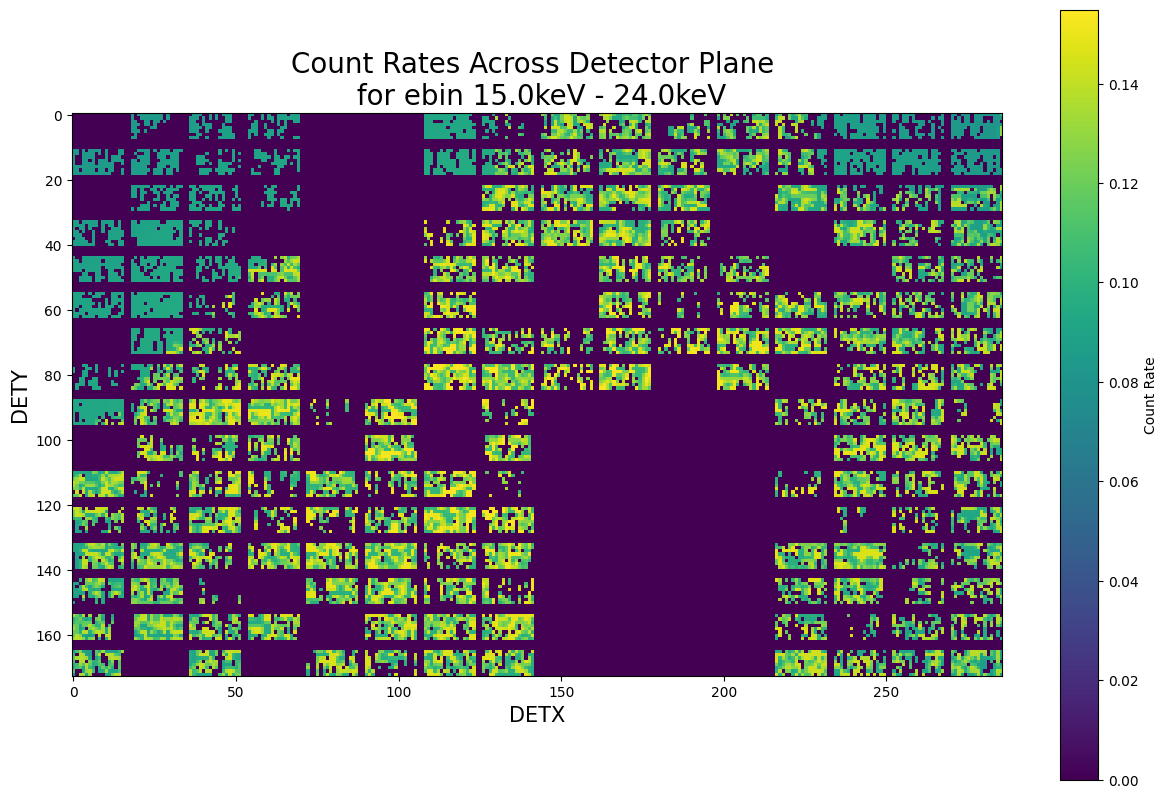

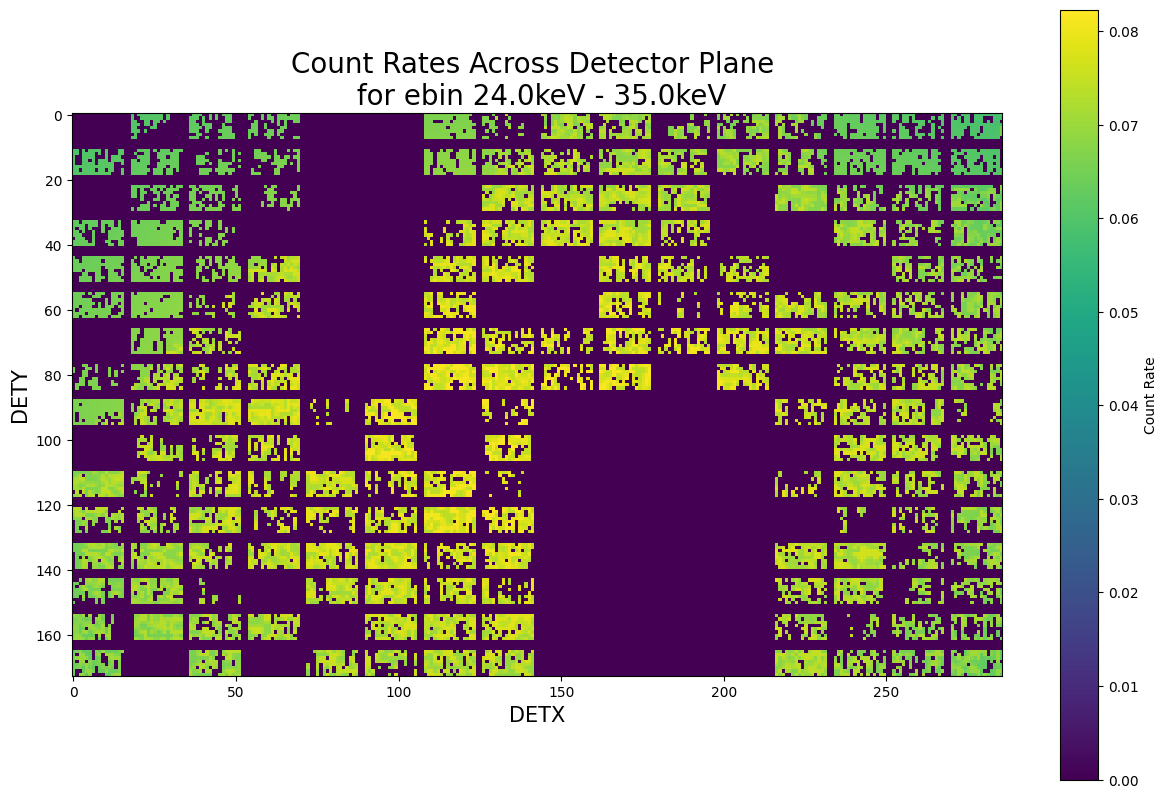

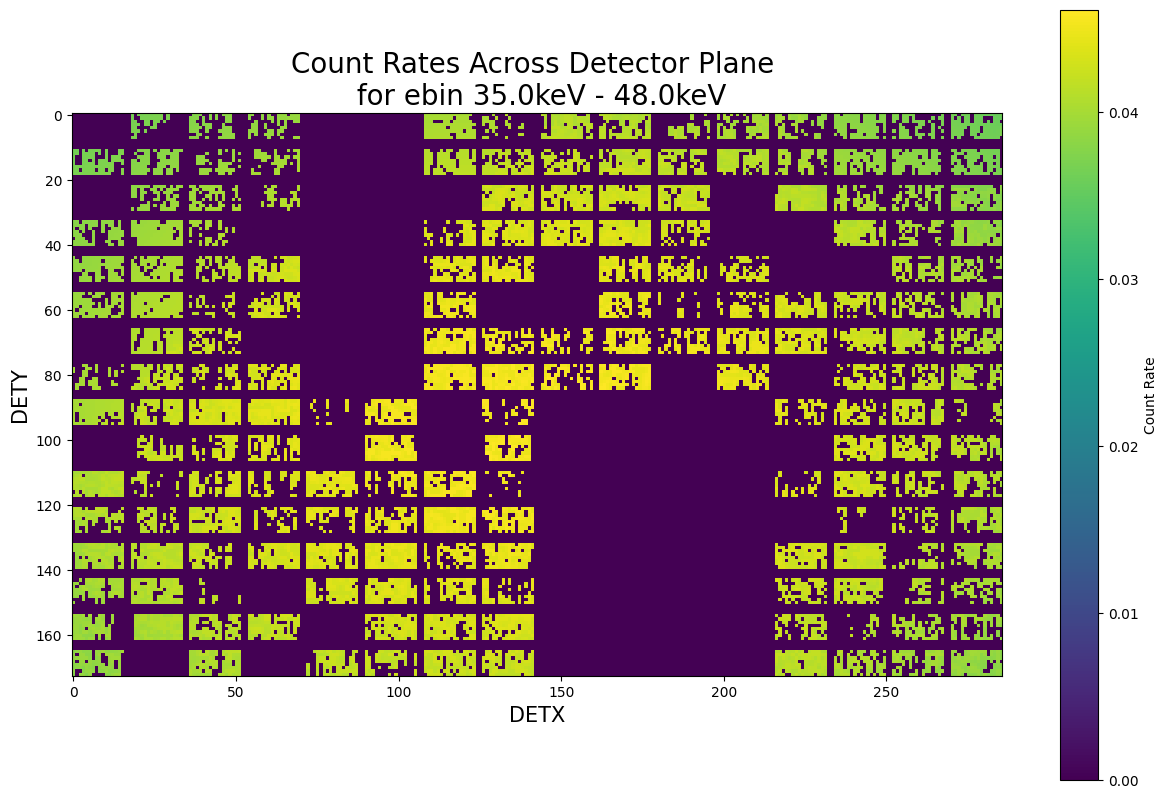

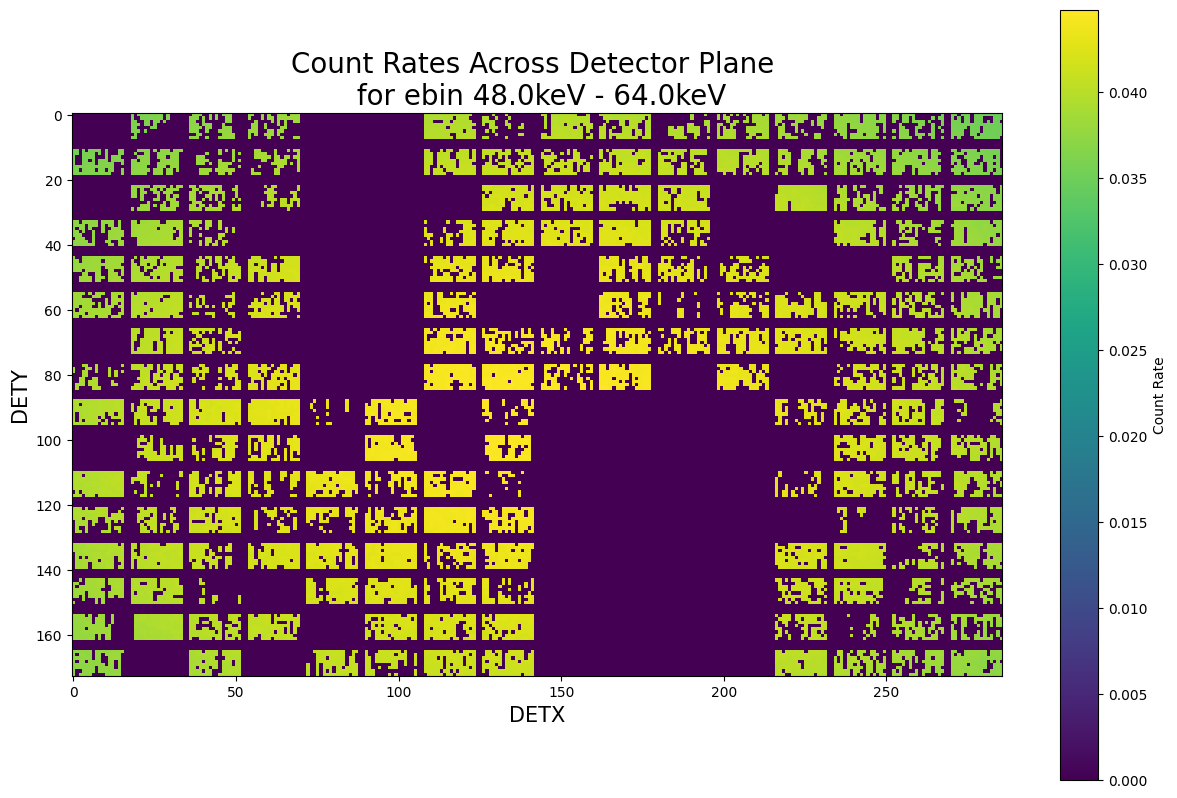

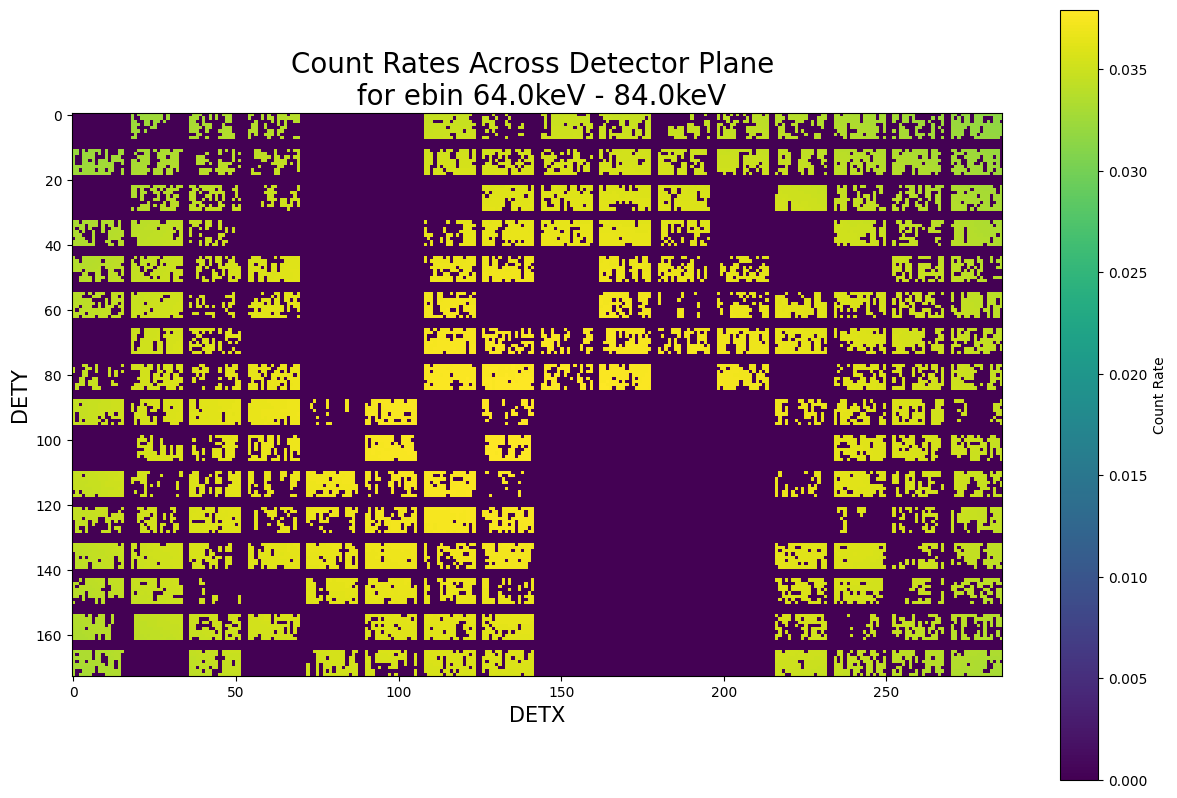

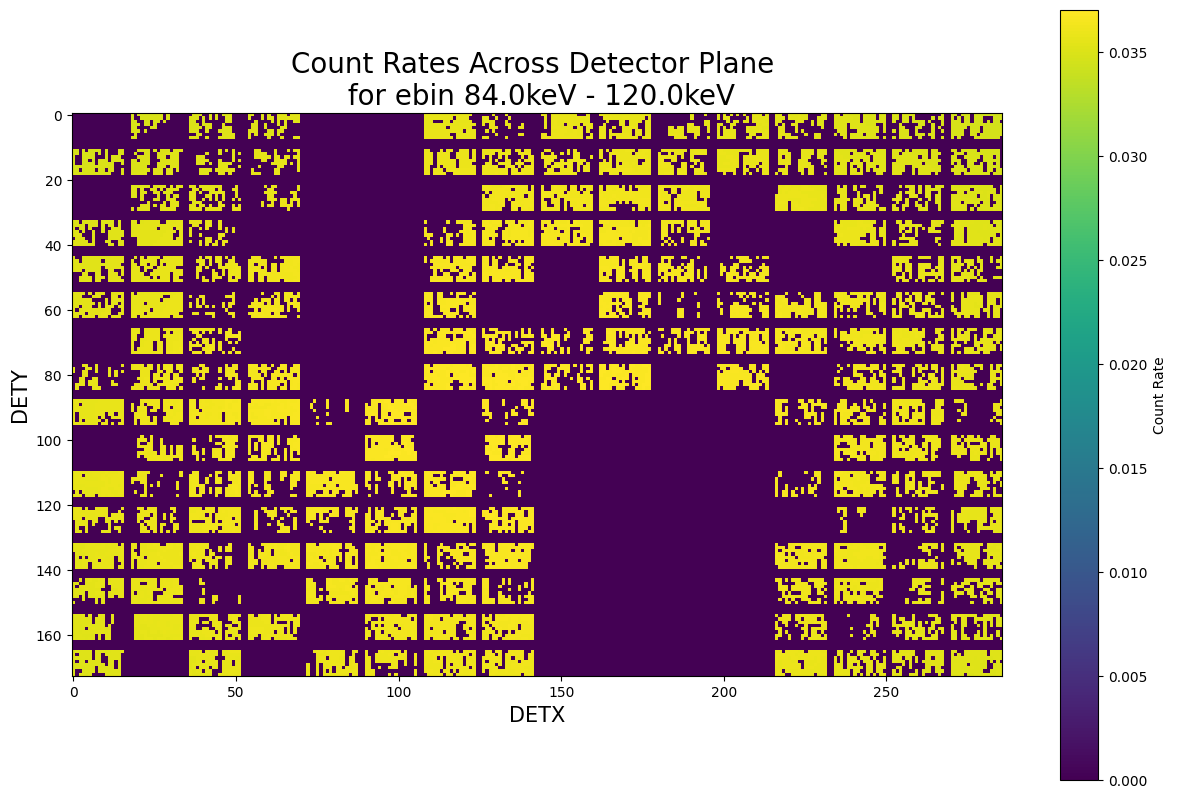

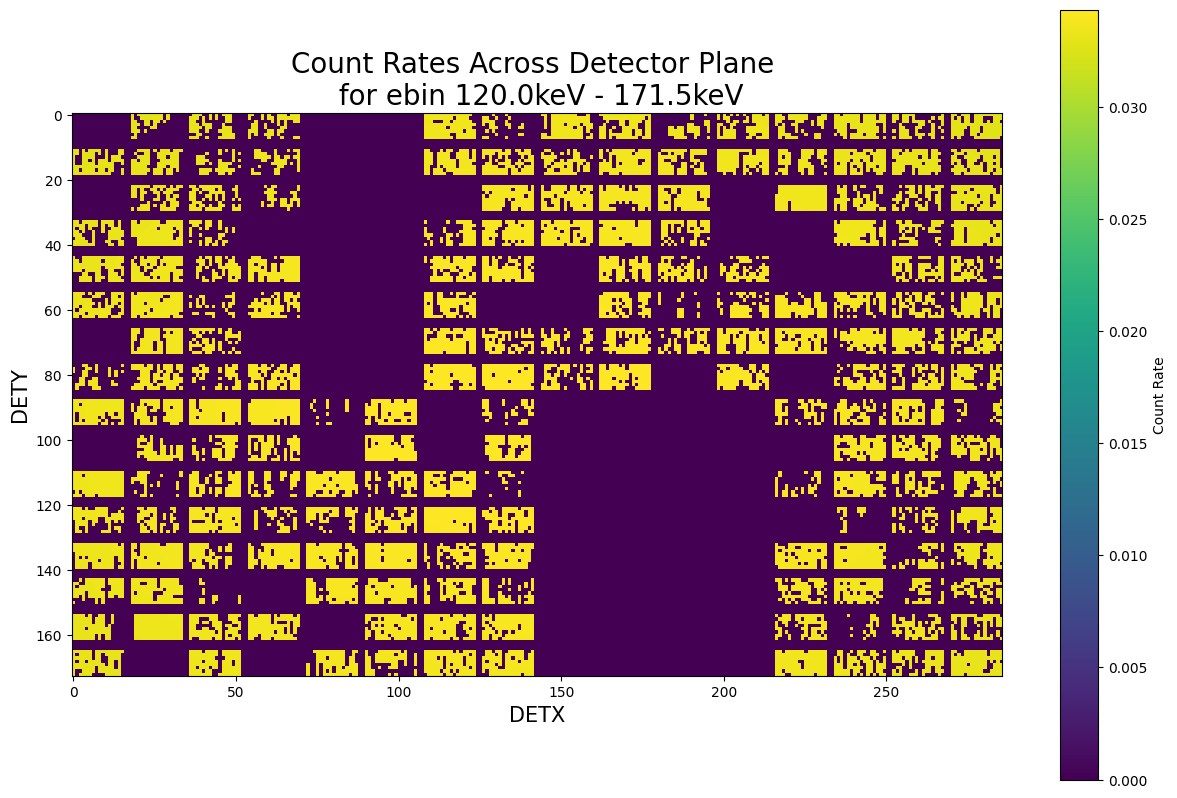

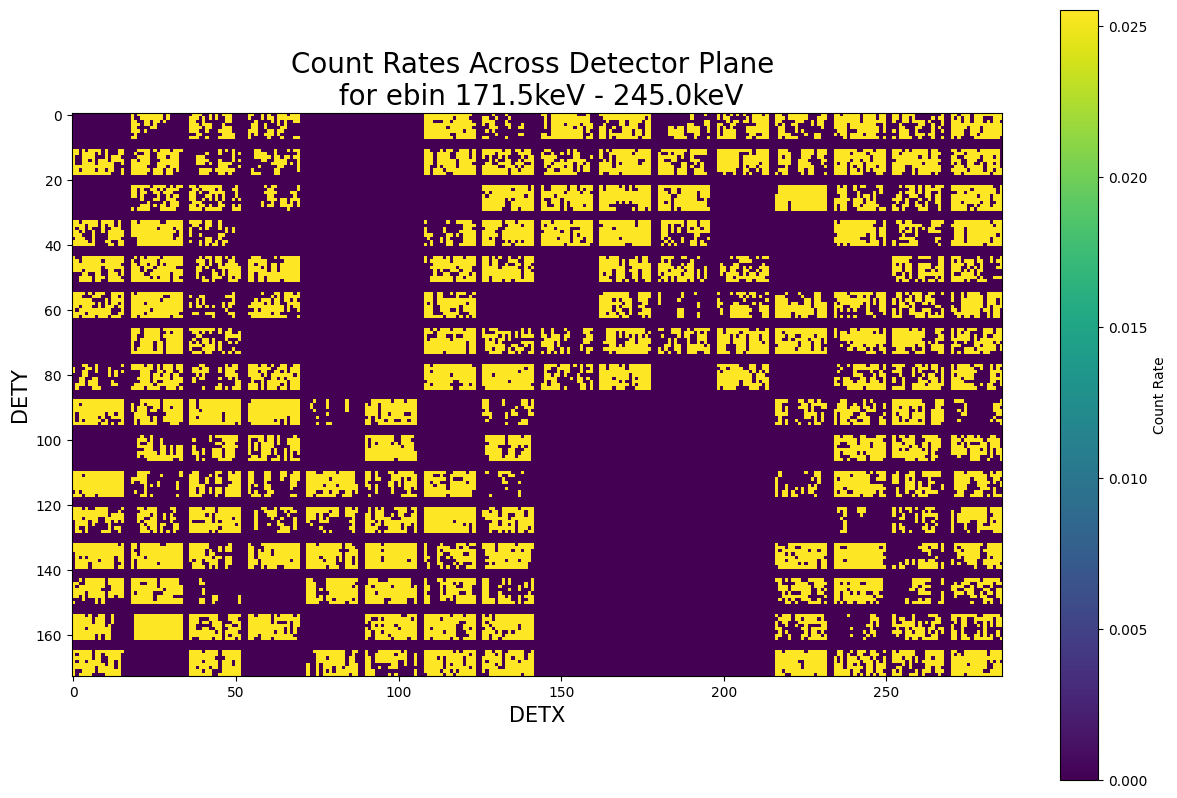

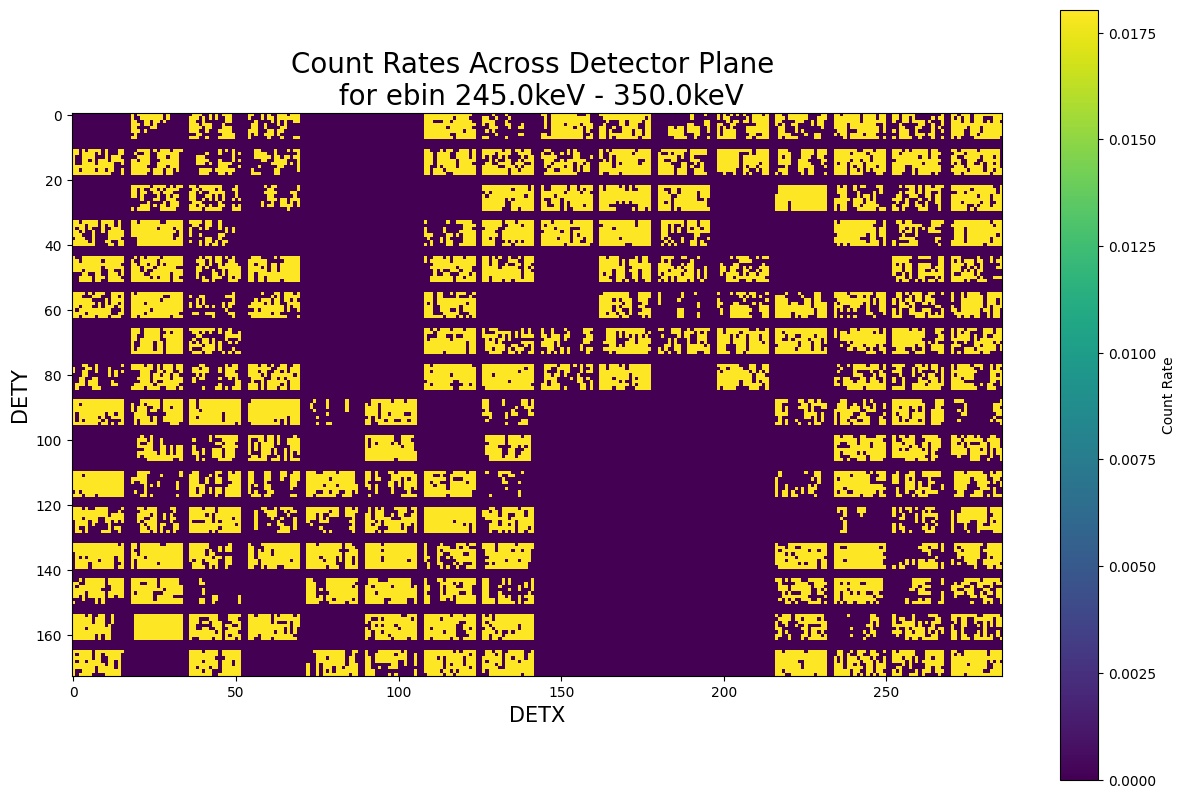

In [76]:
print_ebin_dpi(rate_dpis, dmask, 9)

By comparison to an equivalent dpi of the TTE data separated by ebins, we see this transition towards a flatter dpi occur roughly around the same energy bin of 64.0keV to 84.0keV. Of course, in this specific comparison, we are using our own "eyeballed" background, so it may include more or less of the signal than the background fit. 

Nonetheless, we normalized the TTE dpis so that it is coloured by count rate. The big difference between the TTE dpis and the background fit dpis is in the variability of the counts in the TTE data. For dpis of the same energy bin, note that the bounds for the count rates in the TTE dpis extend higher than the equivalent background fit dpi. The other difference is that by the time we reach the higher energy bins, our background fit tends to undercount the number of detections. For example, for the very last energy bin from 245.0keV to 350.0keV, the background has an essentially flat rate of around 0.0175. In the TTE data, after excluding outliers, the count rates in the equivalent dpi are mostly within the 0.02-0.03 range. 

At the lower energy bins, we have better agreement in the count rates and the distributions of the count rates are nearly equivalent.

[ 15.   24.   35.   48.   64.   84.  120.  171.5 245. ]


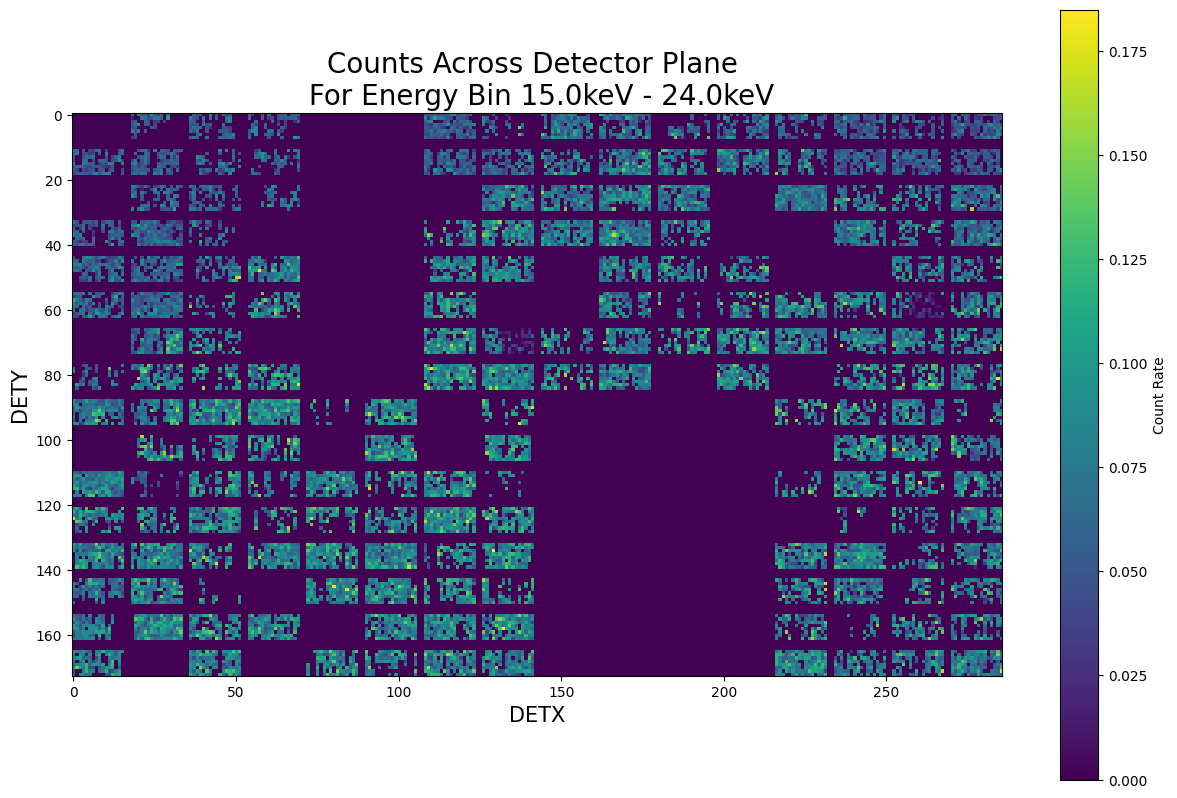

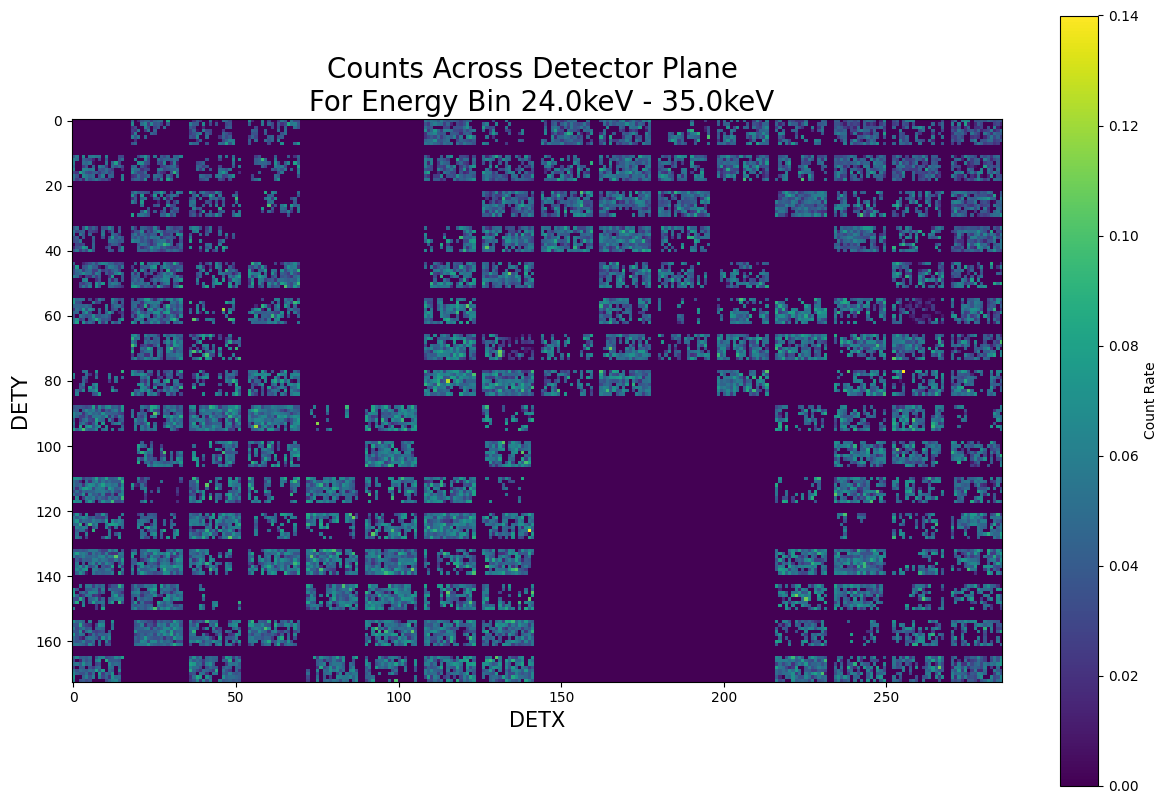

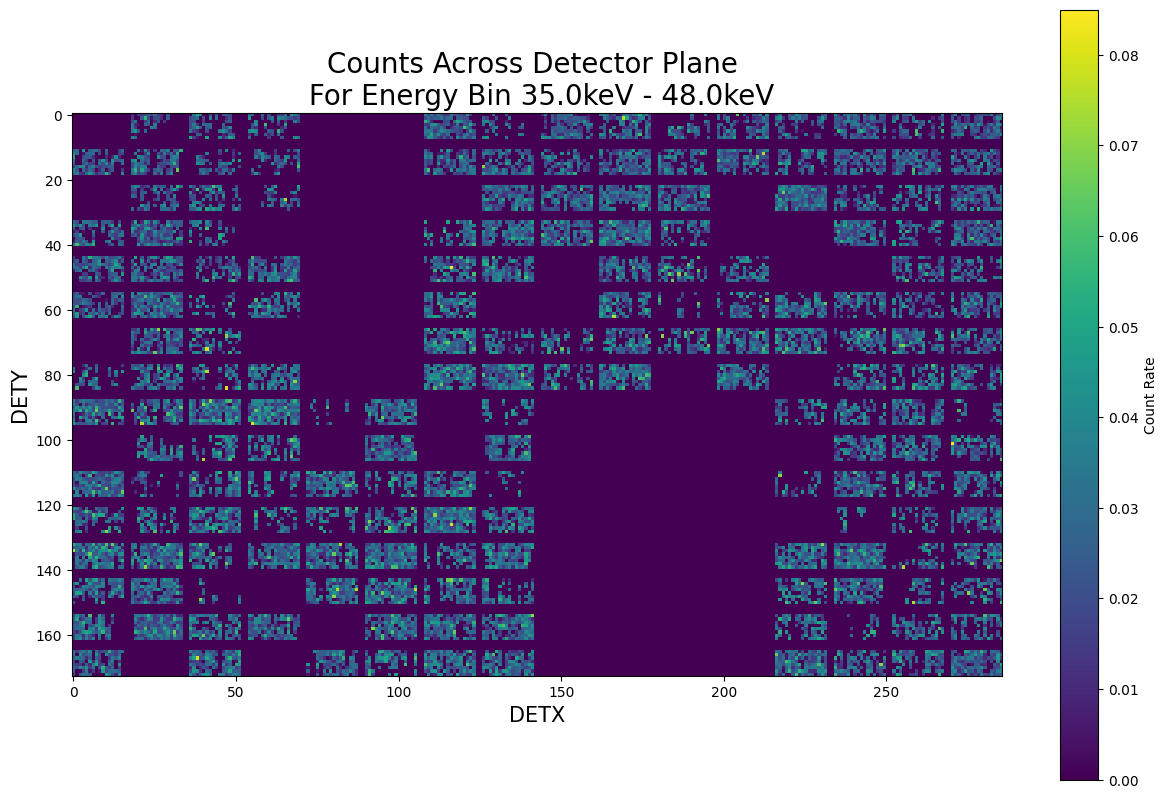

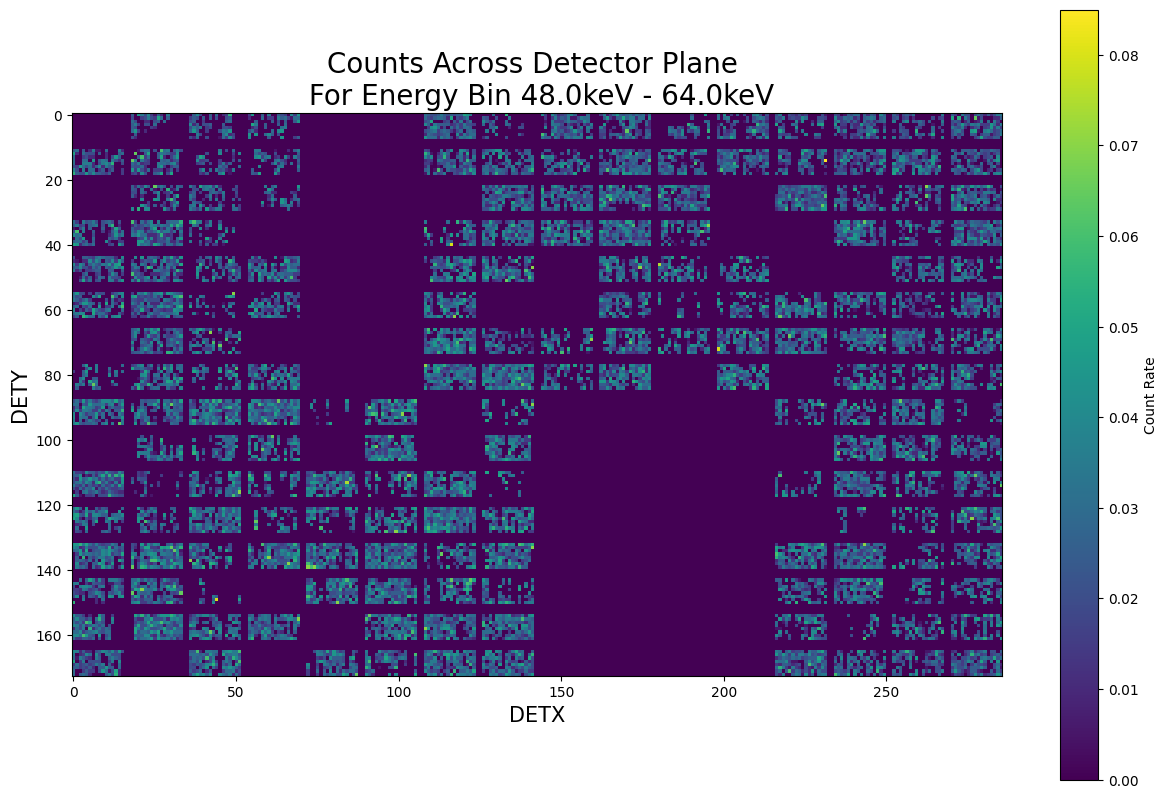

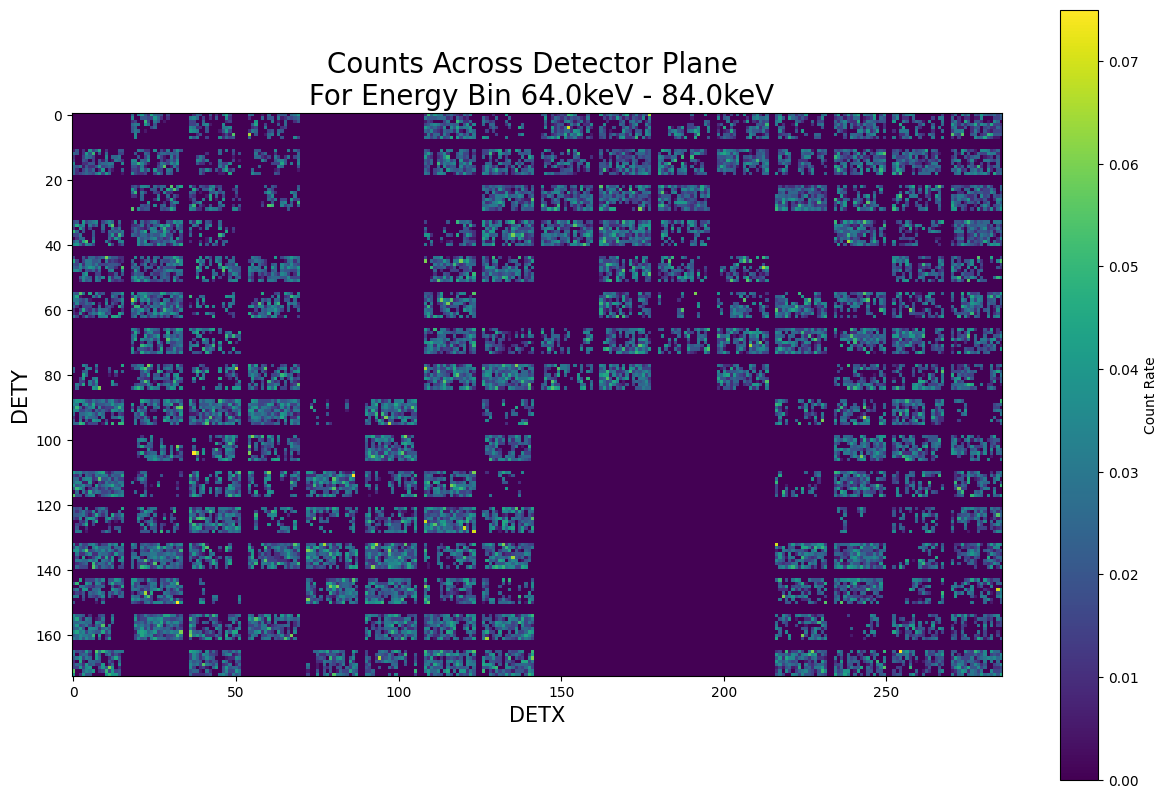

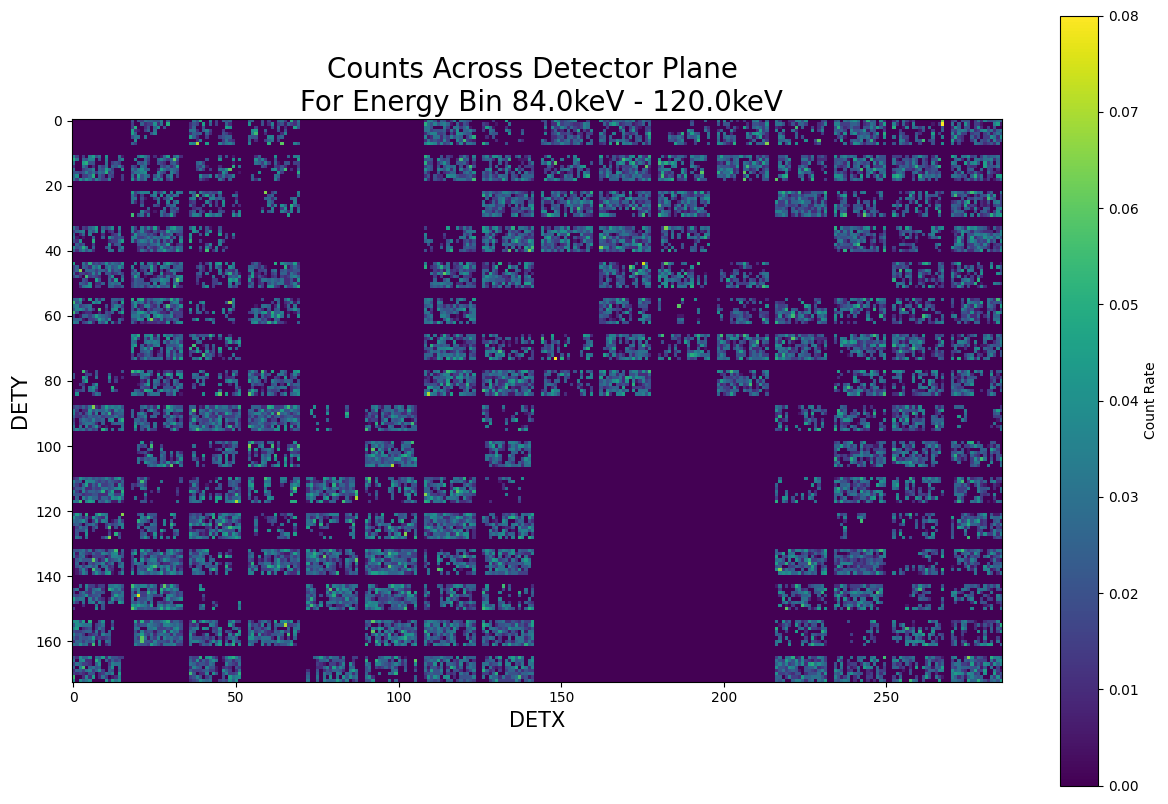

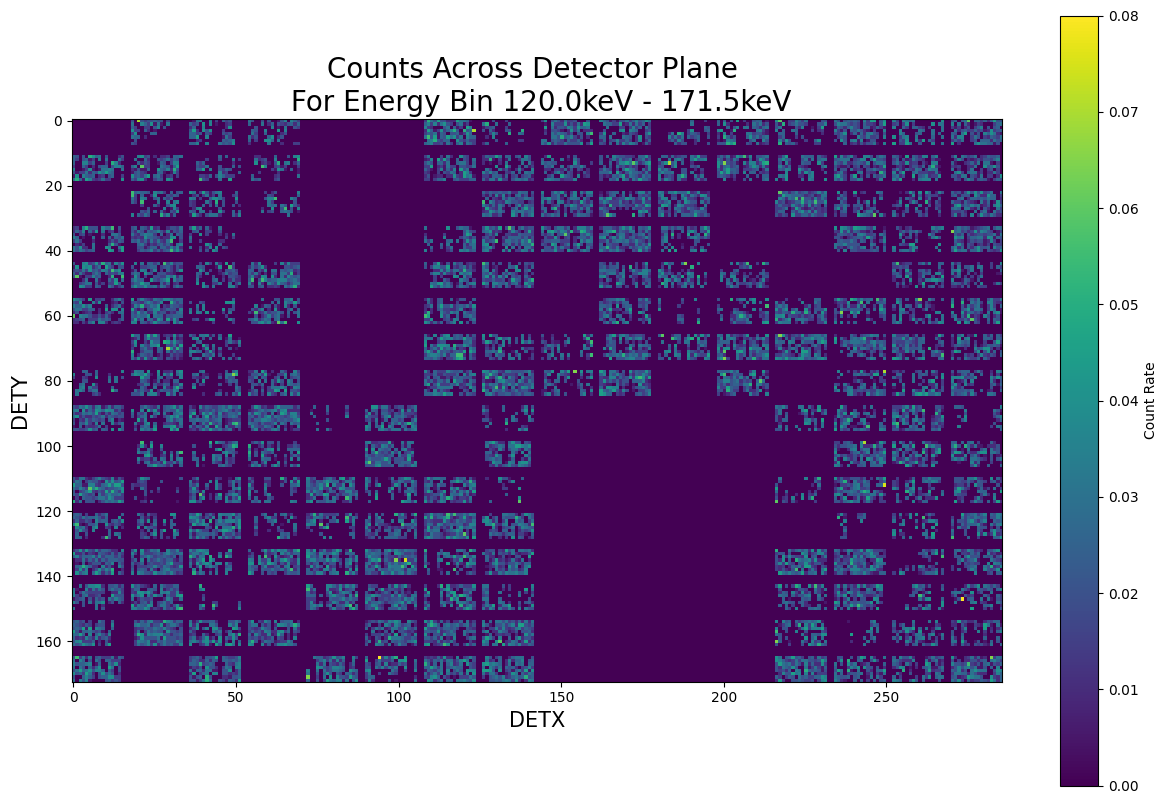

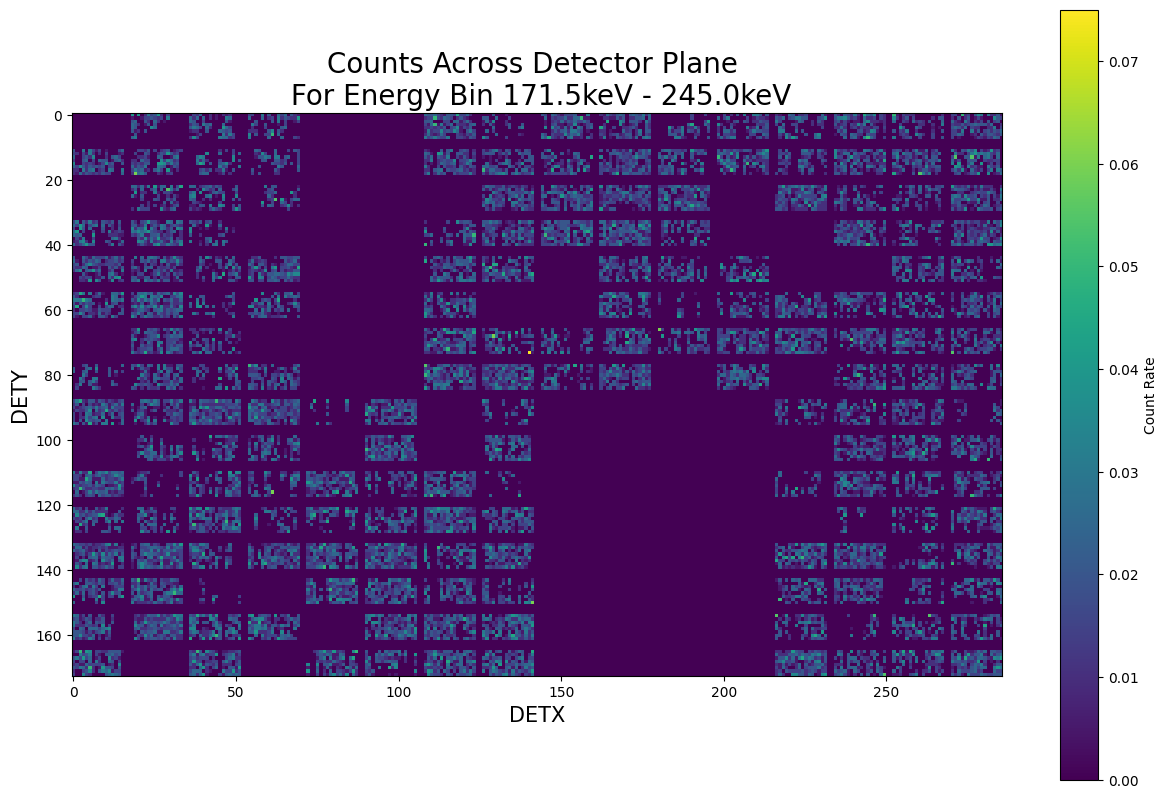

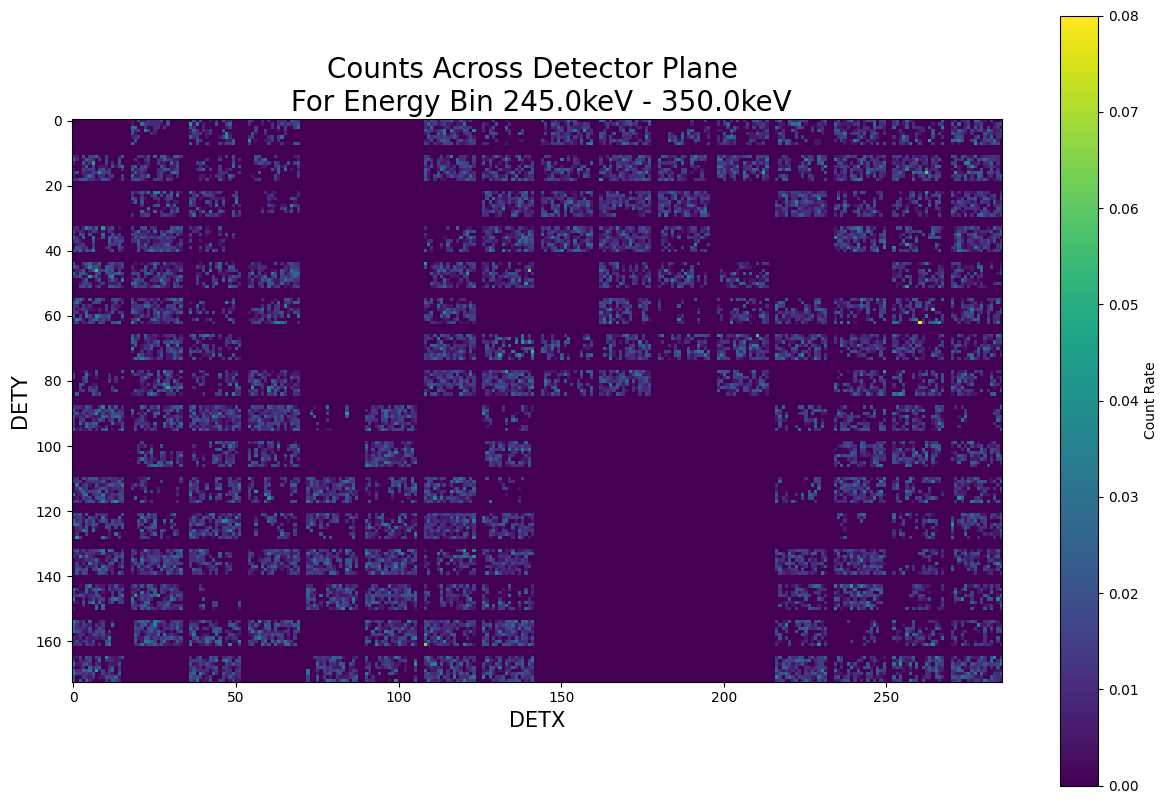

In [77]:
print(ebins0)

for i in range(len(ebins0)):
    energy_bin_data = bkg_data[np.logical_and(bkg_data['ENERGY'] > ebins0[i],bkg_data['ENERGY'] < ebins1[i])]
    
    plt.figure(figsize=(15,10))
    xbins = np.arange(286+1) - 0.5
    ybins = np.arange(173+1) - 0.5
    A, xedges, yedges = np.histogram2d(energy_bin_data['DETX'], energy_bin_data['DETY'], bins=[xbins,ybins])
    A_normed = A/200
    plt.imshow(np.transpose(A_normed),origin="upper") #extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]])
    plt.xlabel("DETX", size=15)
    plt.ylabel("DETY", size=15)
    plt.colorbar(label="Count Rate")
    plt.title("Counts Across Detector Plane \n For Energy Bin {a}keV - {b}keV".format(a=ebins0[i],b=ebins1[i]), size=20)
    plt.show()




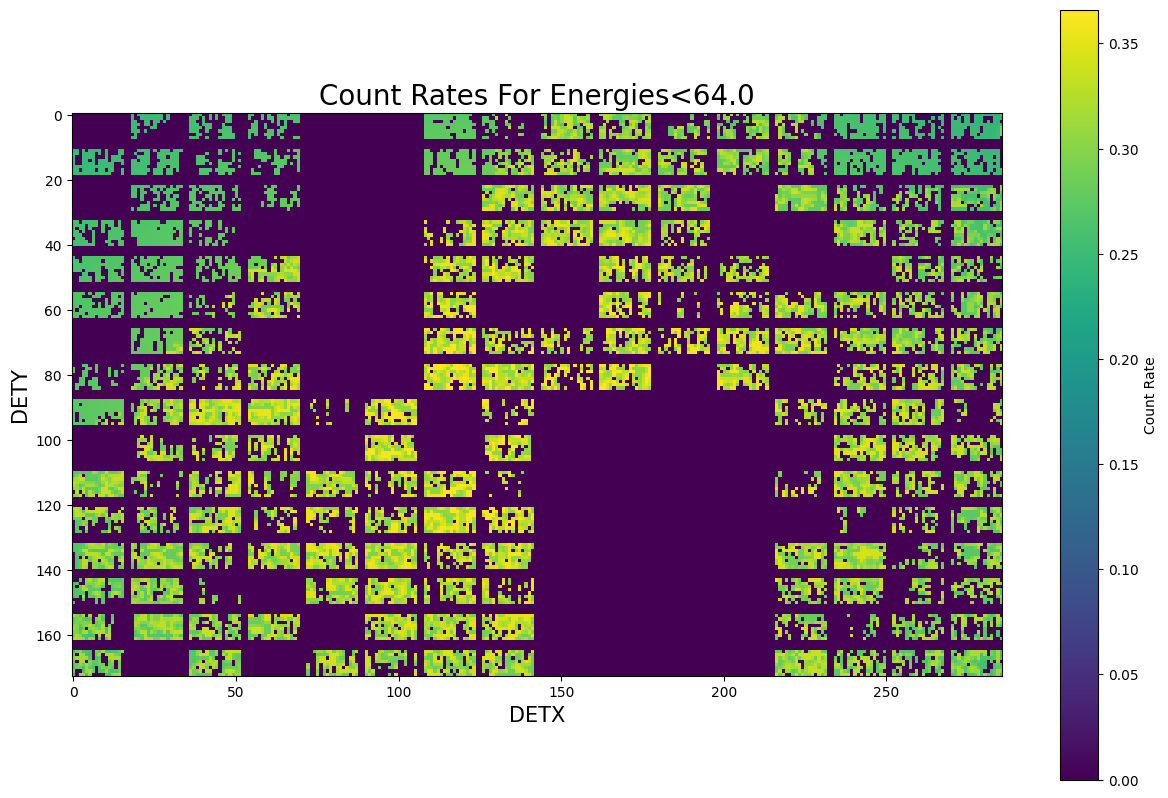

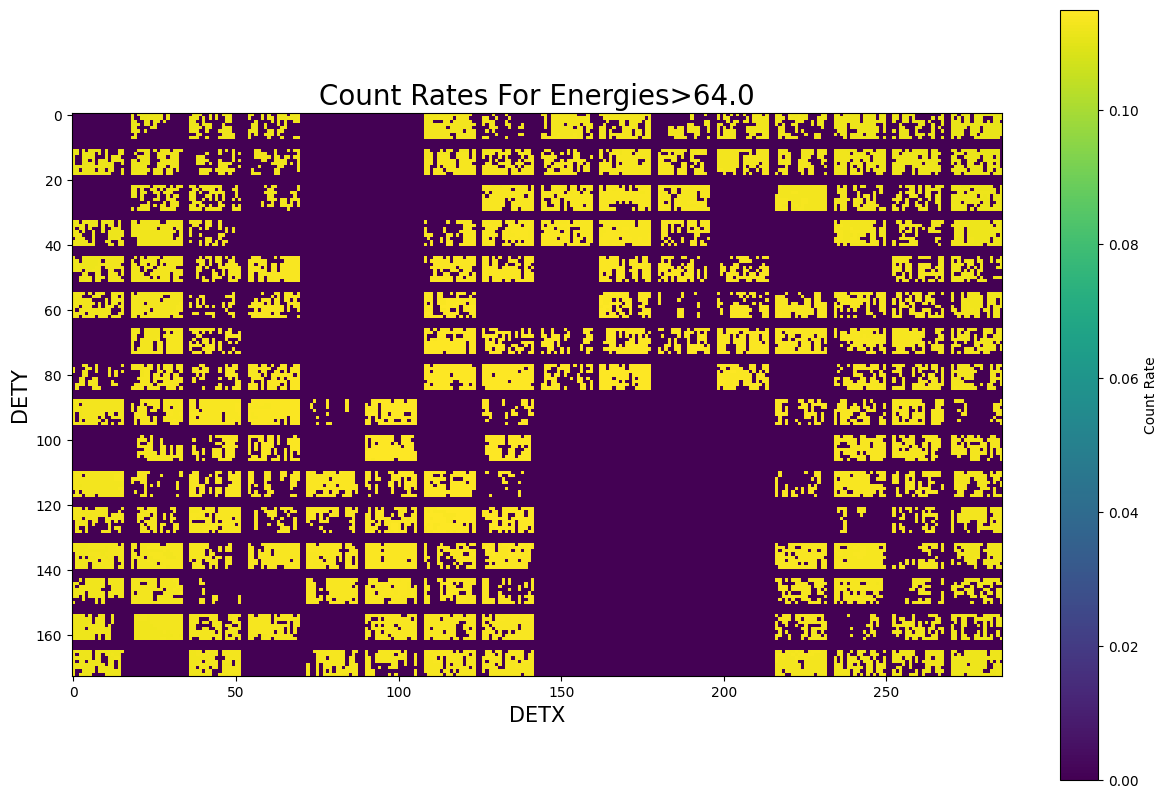

In [78]:
print_low_vs_high_energy_dpi(rate_dpis, dmask, 9, 4)

An alternate way to view the discrepancy between low and high energy counts is in the previous two and the following two plots which show, the dpis for counts below and above 64keV. While the TTE data in this comparison also contains the signal data, the extra counts due to the signal only amount to a trivial increase of counts over the background as was shown in the counts vs time graph towards the beginning. With that said, we can see that while the low energy dpis agrees fairly well in count rate and distribution, the high energy dpi for the background model undercounts by a margin of about 0.02-0.04 counts/s compared to the TTE high energy dpi. Again, we see that the TTE dpi also differs in the distribution of the high energy counts in comparison to the completely uniform dpi for the background fit.

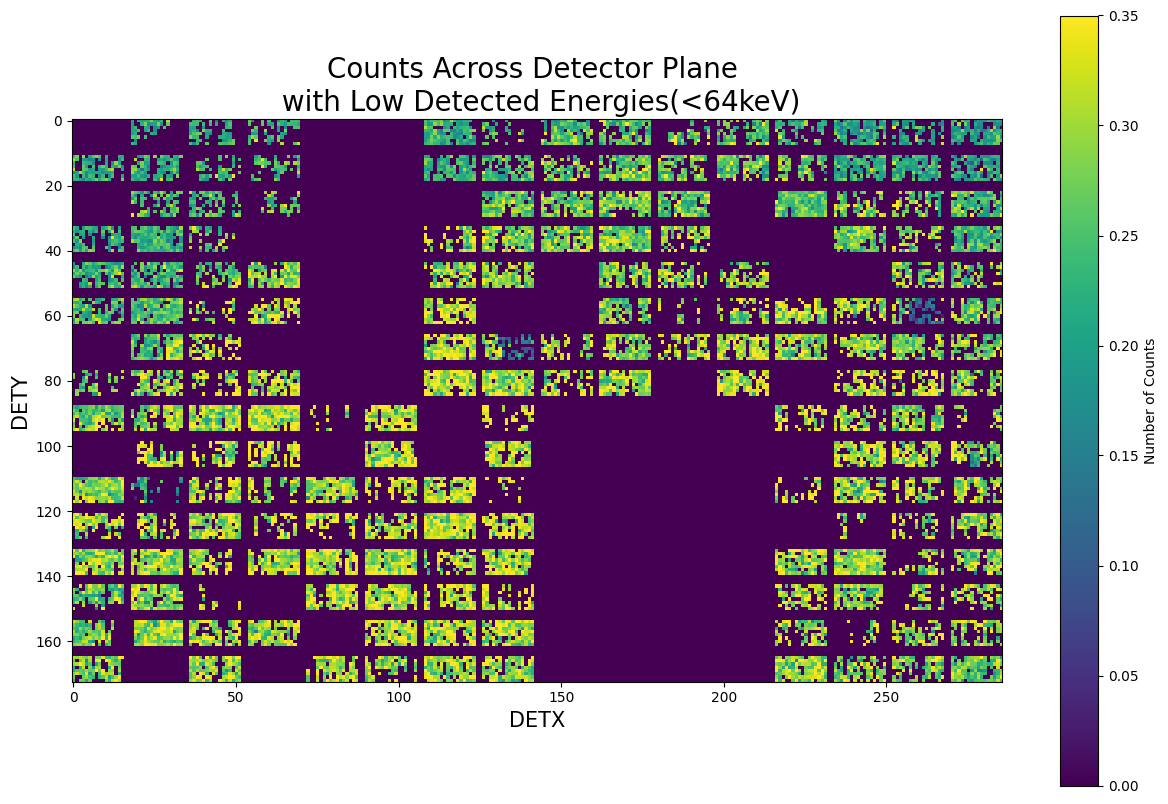

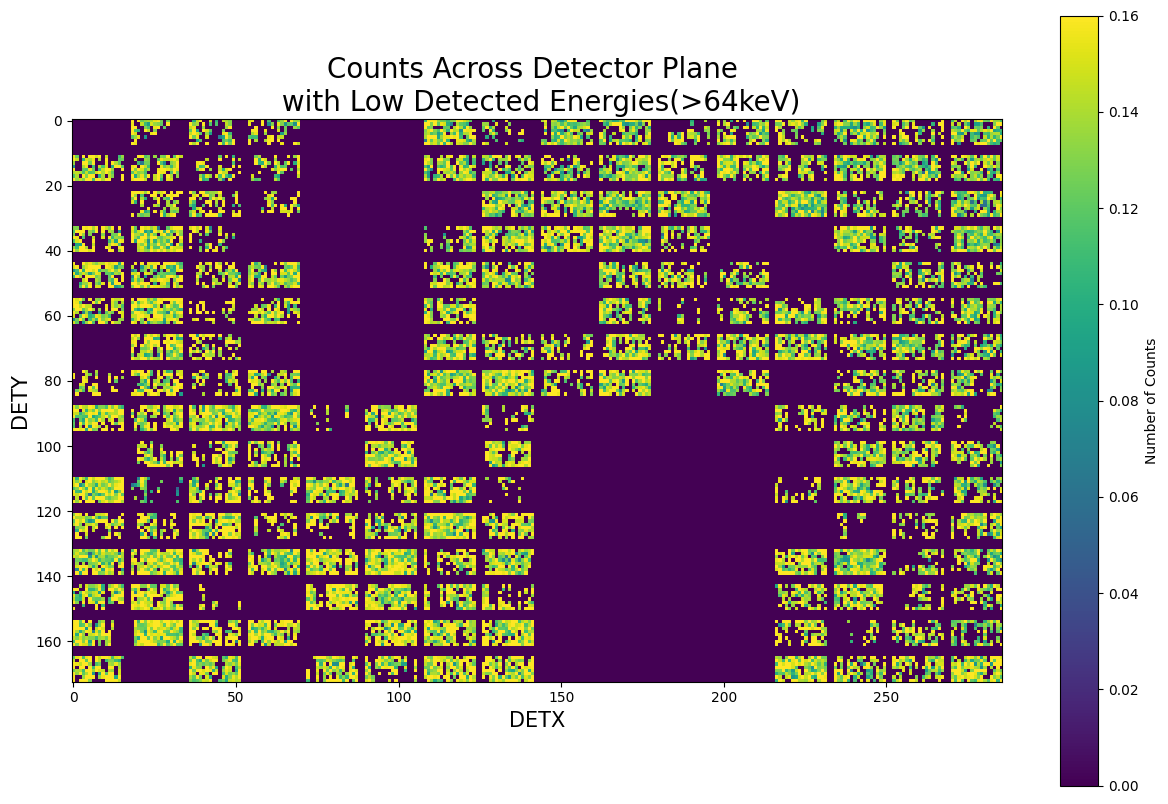

In [79]:
plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
A, xedges, yedges = np.histogram2d(low_energy_data['DETX'], low_energy_data['DETY'], bins=[xbins,ybins])
A_normed = A/200
plt.imshow(np.transpose(A_normed),origin="upper", vmax=0.35) #extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]])
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane \n with Low Detected Energies(<64keV)", size=20)
plt.show()

plt.figure(figsize=(15,10))
xbins = np.arange(286+1) - 0.5
ybins = np.arange(173+1) - 0.5
A, xedges, yedges = np.histogram2d(high_energy_data['DETX'], high_energy_data['DETY'], bins=[xbins,ybins])
A_normed = A/200
plt.imshow(np.transpose(A_normed), vmax=0.16)
plt.xlabel("DETX", size=15)
plt.ylabel("DETY", size=15)
plt.colorbar(label="Number of Counts")
plt.title("Counts Across Detector Plane \n with Low Detected Energies(>64keV)", size=20)
plt.show()